In [6]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display
from glob import glob
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier as RandomForest, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Bidirectional, Reshape, Lambda, Activation, Dense, LSTM, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from keras.optimizers import Adam
from PIL import Image
from tabulate import tabulate
from pprint import pprint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier as Ridge
from imblearn.ensemble import BalancedRandomForestClassifier
import time
from keras.utils import load_img, img_to_array
from keras.callbacks import Callback
AUTOTUNE = tf.data.AUTOTUNE

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/preprocessed_extracted_features_iemocap.csv"
ALL_EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/preprocessed_all_extracted_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTROGRAMS_DIR = './../data/spectrograms/'
AUDIO_MFCCS_DIR = './../data/mfccs/'
AUDIO_MEL_SPECTROGRAMS_DIR = './../data/mel_spectrograms/'
AUDIO_MEL_SPECTROGRAM_IMAGES_DIR = './../data/mel_spectrograms_images/'
AUDIO_ALL_DATA_DIR = './../data/all_data/'

config = Configuration.load_json(CONFIG_FILE)
# !pip install autokeras
# !pip install --upgrade scipy==1.7.0
# !pip install auto-sklearn
import autokeras as ak
# from autosklearn.classification import AutoSklearnClassifier
# from autosklearn.regression import AutoSklearnRegressor

OneHotEncodingConfig = {'0': [1, 0, 0, 0], '1': [0, 1, 0, 0], '2': [0, 0, 1, 0], '3': [0, 0, 0, 1]}
plt.rcParams['figure.dpi'] = 300

In [7]:
def get_metrics(y_labels, y_pred, folds_size, train_times, prediction_times, draw_corr_matrix=True):
    accs = []
    i = 0
    for f_i in range(5):
      acc = round(metrics.accuracy_score(
          y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
      print(f"Accuracy for fold {f_i}: {acc}%")
      accs.append(acc)
      i += folds_size[f_i]

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Training Time", f"{round(np.sum(train_times), 2)}+-{round(np.std(train_times), 2)}"],
        ["Prediction Time", f"{round(np.sum(prediction_times), 2)}+-{round(np.std(prediction_times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred, normalize='all')
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()


## Read the extracted features from the CSV

In [8]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.set_index('File')
df

Number of Audio Files: 5531


Interaction  Gender  Original_Duration  Duration  \
File                                                                      
Ses01F_impro01_F000     improvised  Female           1.945563  1.945563   
Ses01F_impro01_F001     improvised  Female           1.382437  1.382437   
Ses01F_impro01_F002     improvised  Female           3.130250  3.130250   
Ses01F_impro01_F005     improvised  Female           4.029937  4.029937   
Ses01F_impro01_F012     improvised  Female           2.750000  2.750000   
...                            ...     ...                ...       ...   
Ses05M_script03_2_M041    scripted    Male           8.259937  8.259937   
Ses05M_script03_2_M042    scripted    Male           1.740000  1.740000   
Ses05M_script03_2_M043    scripted    Male           2.239937  2.239937   
Ses05M_script03_2_M044    scripted    Male           4.469938  4.469938   
Ses05M_script03_2_M045    scripted    Male           6.009938  6.009938   

                        Emotion  Emotion_Id  Valence  Activation  Dominance  \
File                                                                          
Ses01F_impro01_F000     neutral           3      2.5         2.5        2.5   
Ses01F_impro01_F001     neutral           3      2.5         2.5        2.5   
Ses01F_impro01_F002     neutral           3      2.5         2.5        2.5   
Ses01F_impro01_F005     neutral           3      2.5         3.5        2.0   
Ses01F_impro01_F012       angry           0      2.0         3.5        3.5   
...                         ...         ...      ...         ...        ...   
Ses05M_script03_2_M041    angry           0      1.0         4.5        5.0   
Ses05M_script03_2_M042    angry           0      1.0         4.5        4.5   
Ses05M_script03_2_M043    angry           0      1.5         4.0        4.5   
Ses05M_script03_2_M044    angry           0      1.0         5.0        5.0   
Ses05M_script03_2_M045    angry           0      1.0         5.0        5.0   

                         min_zcr  ...  kurtosis_mfcc12  mean_mfcc13  \
File                              ...                                 
Ses01F_impro01_F000     0.043457  ...         1.847625    -1.540581   
Ses01F_impro01_F001     0.049805  ...        -1.161598     4.465957   
Ses01F_impro01_F002     0.026367  ...         1.460540     0.620563   
Ses01F_impro01_F005     0.032715  ...         0.287041    -5.985569   
Ses01F_impro01_F012     0.033203  ...        -0.320905    -8.757206   
...                          ...  ...              ...          ...   
Ses05M_script03_2_M041  0.023438  ...        -0.202920    -8.155182   
Ses05M_script03_2_M042  0.073730  ...        -0.383311    -8.762004   
Ses05M_script03_2_M043  0.039062  ...         0.060354    -5.940704   
Ses05M_script03_2_M044  0.026367  ...         1.556388   -10.050160   
Ses05M_script03_2_M045  0.029297  ...         0.811775    -7.257350   

                        mean_mfcc15  spikes_mfcc16  kurtosis_mfcc17  \
File                                                                  
Ses01F_impro01_F000       -2.325232       0.311475        -0.842359   
Ses01F_impro01_F001        0.864404       0.500000        -1.147906   
Ses01F_impro01_F002       -0.529402       0.609756         1.381224   
Ses01F_impro01_F005      -13.463417       0.523256         0.658782   
Ses01F_impro01_F012       -8.404855       0.500000         0.866702   
...                             ...            ...              ...   
Ses05M_script03_2_M041    -5.028876       0.513889         0.986282   
Ses05M_script03_2_M042    -7.851655       0.500000        -0.699772   
Ses05M_script03_2_M043    -5.136125       0.424242        -0.795263   
Ses05M_script03_2_M044   -10.719204       0.474453         0.265271   
Ses05M_script03_2_M045    -3.092519       0.367742         0.995303   

                        mean_mfcc17  kurtosis_mfcc18  spikes_mfcc19  \
File                                                                  
Ses01F_impro01_F000       -0.

## Data used in SOA models

In [13]:
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
sad     2             1084
neutral 3             1708

# Categorical Problem (anger, happiness (+ excited), neutral, sadness)

## Models

### Simple Random Forests

In [14]:
def categorical_cross_validation(get_new_model, cv=5, draw_corr_matrix=True):
    train_times = []
    prediction_times = []
    folds_size = []

    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        folds_size.append(len(y_test))

        start_time = time.time()
        model.fit(X_train, y_train.values.ravel())
        train_times.append(time.time() - start_time)

        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_times.append(time.time() - start_time)

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test.values.ravel())

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, folds_size, train_times, prediction_times, draw_corr_matrix)

Accuracy for fold 0: 58.54%
Accuracy for fold 1: 60.13%
Accuracy for fold 2: 59.95%
Accuracy for fold 3: 59.58%
Accuracy for fold 4: 59.22%

Metric             Value
-----------------  -----------
Accuracy           59.48+-0.57
F1 score macro     60.07
Precision          60.59
Recall             59.94
Matthews corrcoef  0.451
Training Time      7.48+-0.02
Prediction Time    0.38+-0.0

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1103
           1       0.56      0.49      0.52      1636
           2       0.65      0.67      0.66      1084
           3       0.56      0.66      0.60      1708

    accuracy                           0.59      5531
   macro avg       0.61      0.60      0.60      5531
weighted avg       0.60      0.59      0.59      5531



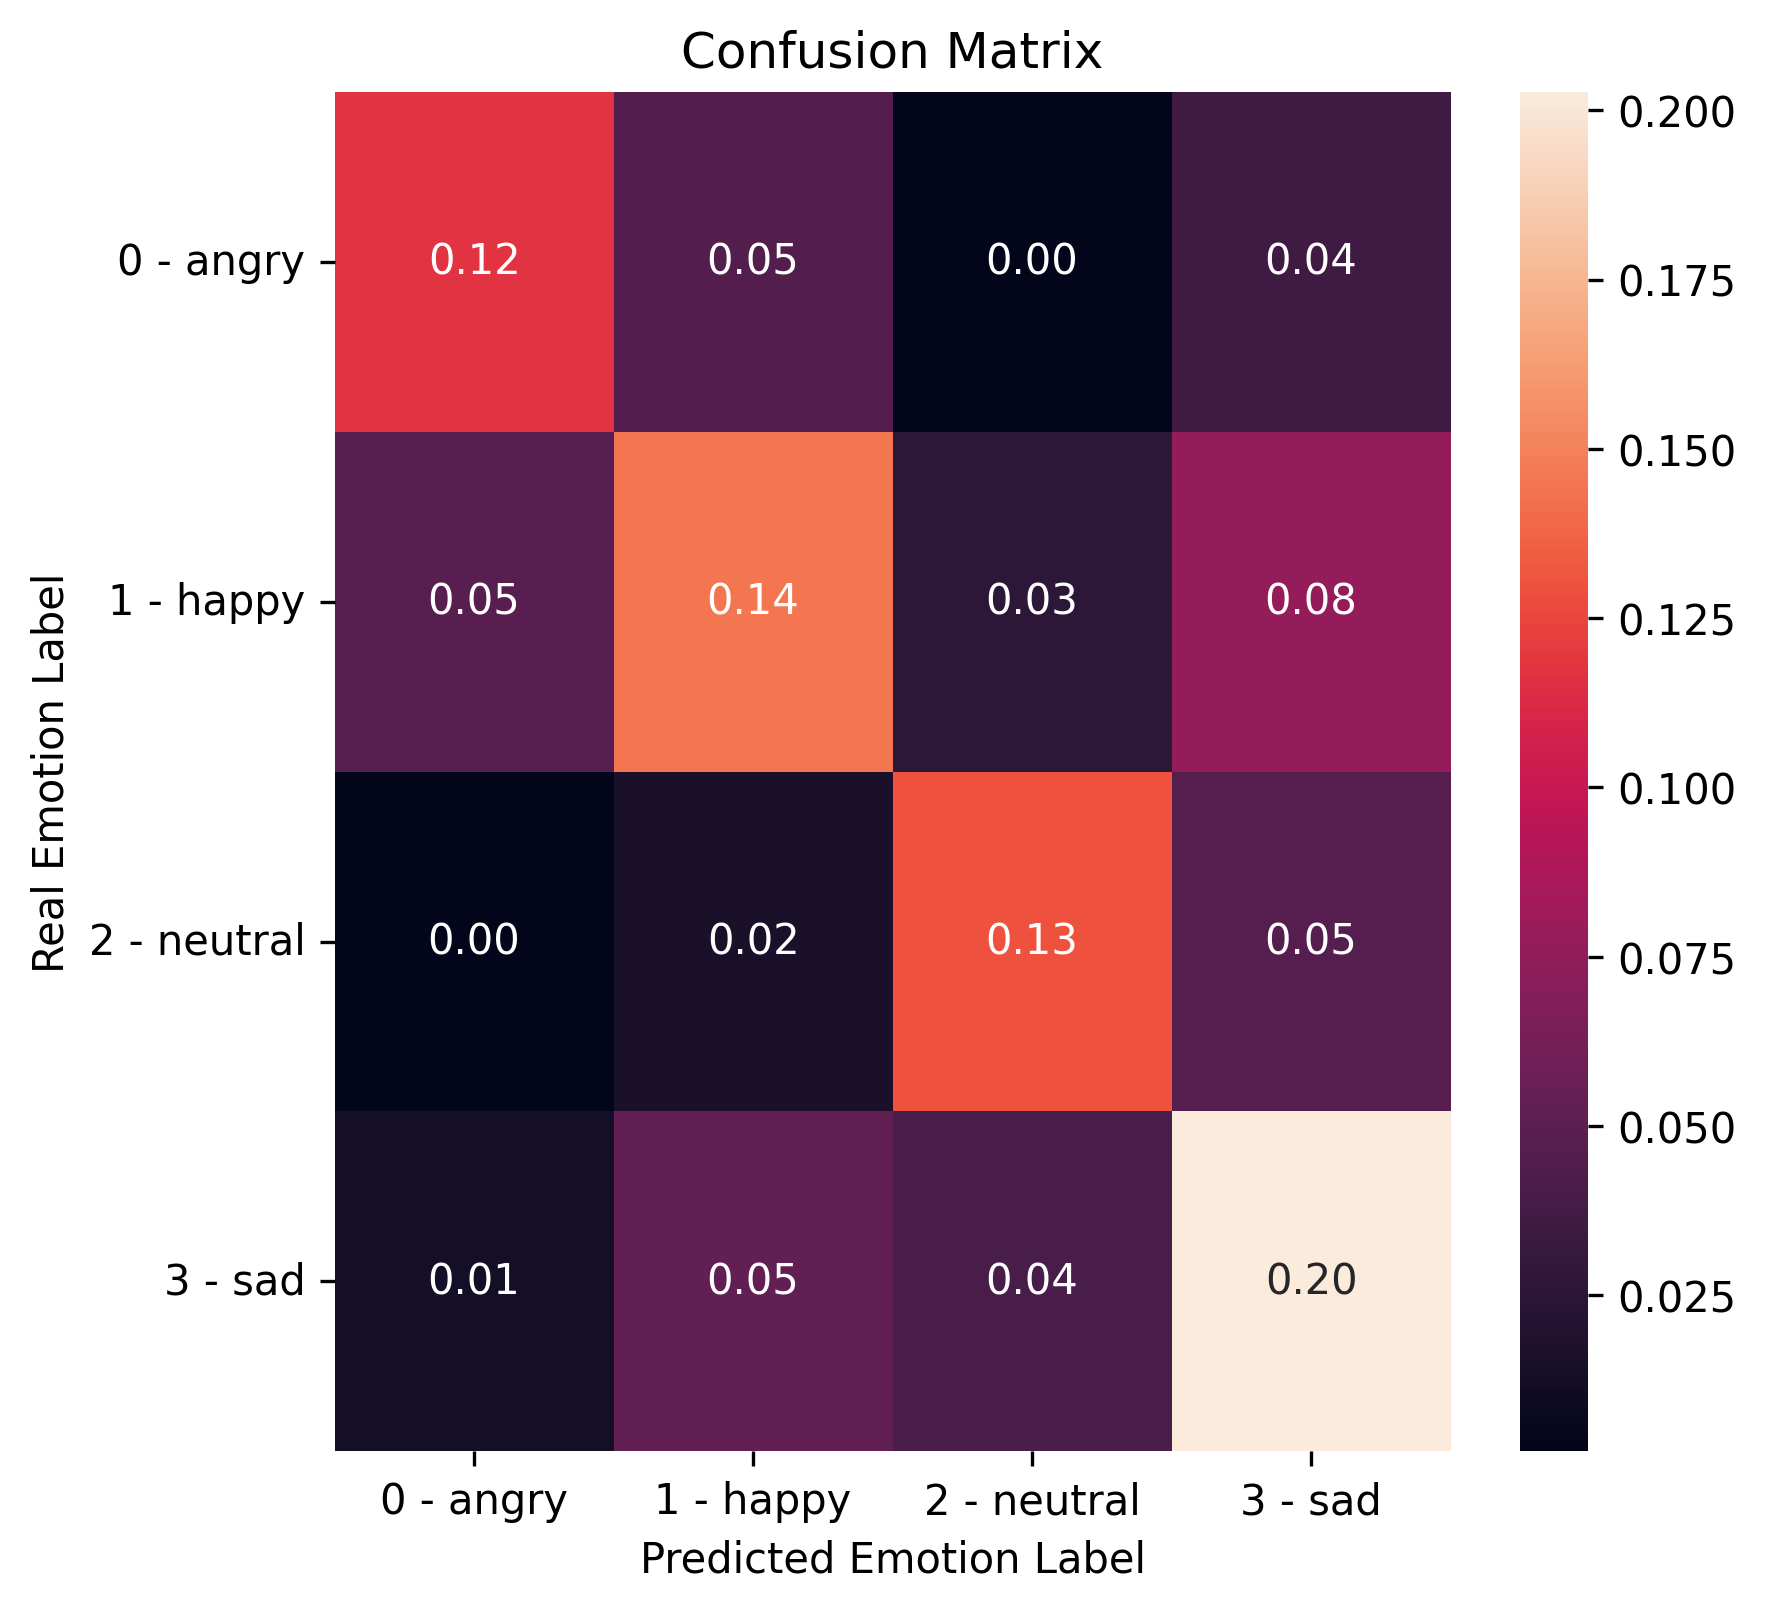

In [15]:
def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
categorical_cross_validation(get_new_model)

### XGBoost

Accuracy for fold 0: 57.99%
Accuracy for fold 1: 57.32%
Accuracy for fold 2: 59.4%
Accuracy for fold 3: 59.67%
Accuracy for fold 4: 56.06%

Metric             Value
-----------------  -----------
Accuracy           58.09+-1.34
F1 score macro     58.74
Precision          59.3
Recall             58.44
Matthews corrcoef  0.431
Training Time      7.37+-0.05
Prediction Time    0.02+-0.0

              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1103
           1       0.53      0.50      0.51      1636
           2       0.65      0.64      0.65      1084
           3       0.55      0.63      0.59      1708

    accuracy                           0.58      5531
   macro avg       0.59      0.58      0.59      5531
weighted avg       0.58      0.58      0.58      5531



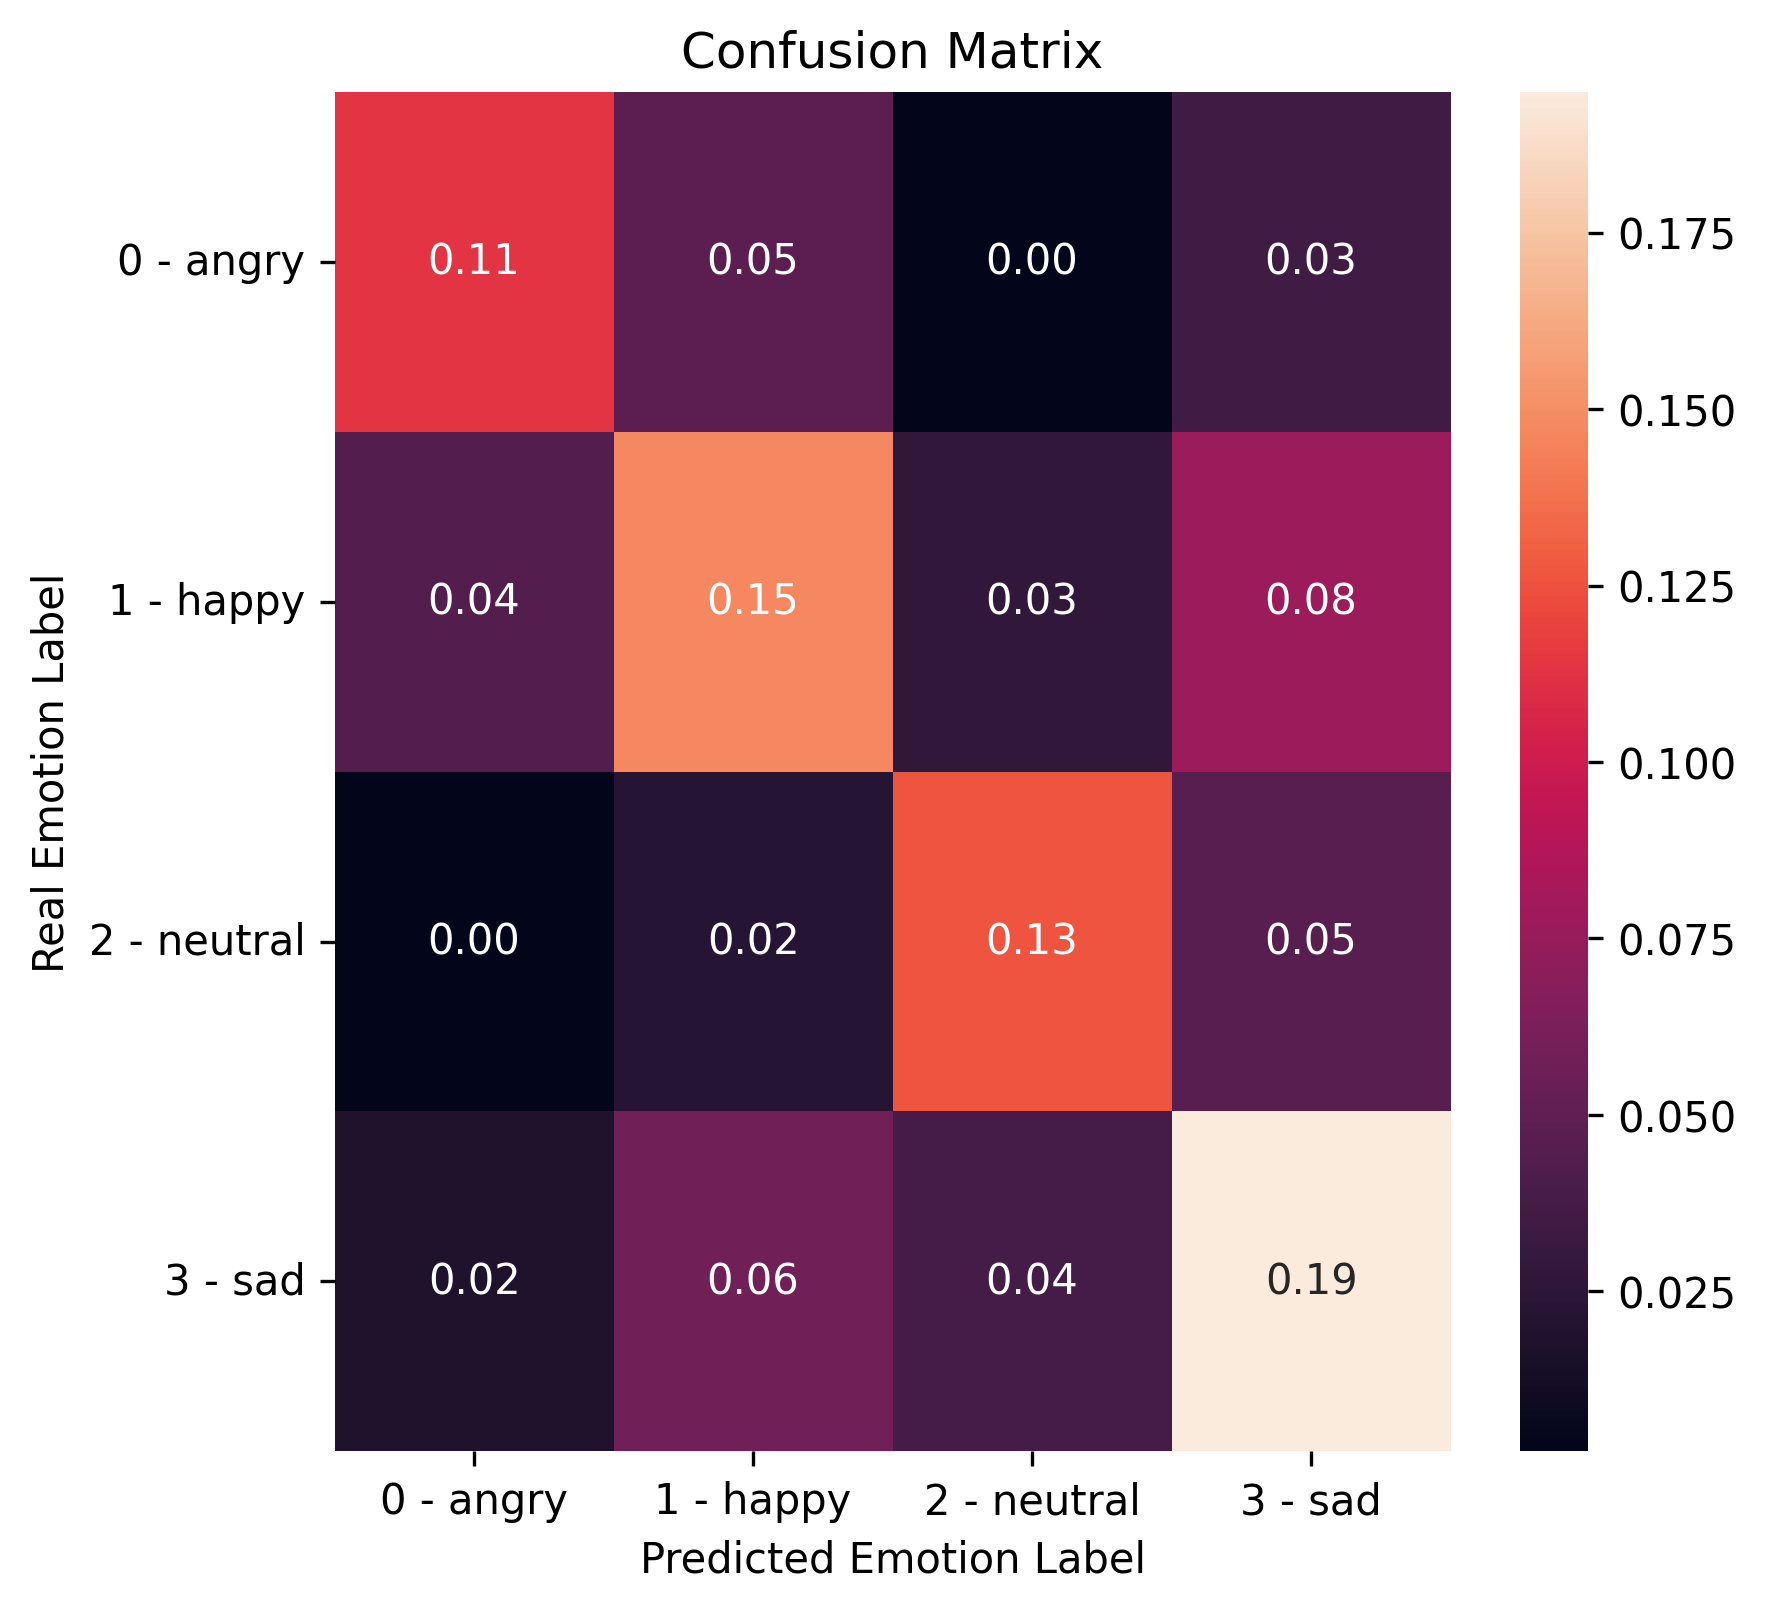

In [16]:
from xgboost import XGBClassifier as XGB
def get_new_model():
    return XGB(random_state=1, objective="multi:softprob")
categorical_cross_validation(get_new_model)

### Ridge Classifier

Accuracy for fold 0: 53.03%
Accuracy for fold 1: 52.35%
Accuracy for fold 2: 52.17%
Accuracy for fold 3: 54.34%
Accuracy for fold 4: 54.52%

Metric             Value
-----------------  -----------
Accuracy           53.28+-0.98
F1 score macro     54.14
Precision          53.94
Recall             54.44
Matthews corrcoef  0.369
Training Time      0.02+-0.0
Prediction Time    0.01+-0.0

              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1103
           1       0.50      0.47      0.49      1636
           2       0.59      0.65      0.62      1084
           3       0.50      0.51      0.50      1708

    accuracy                           0.53      5531
   macro avg       0.54      0.54      0.54      5531
weighted avg       0.53      0.53      0.53      5531



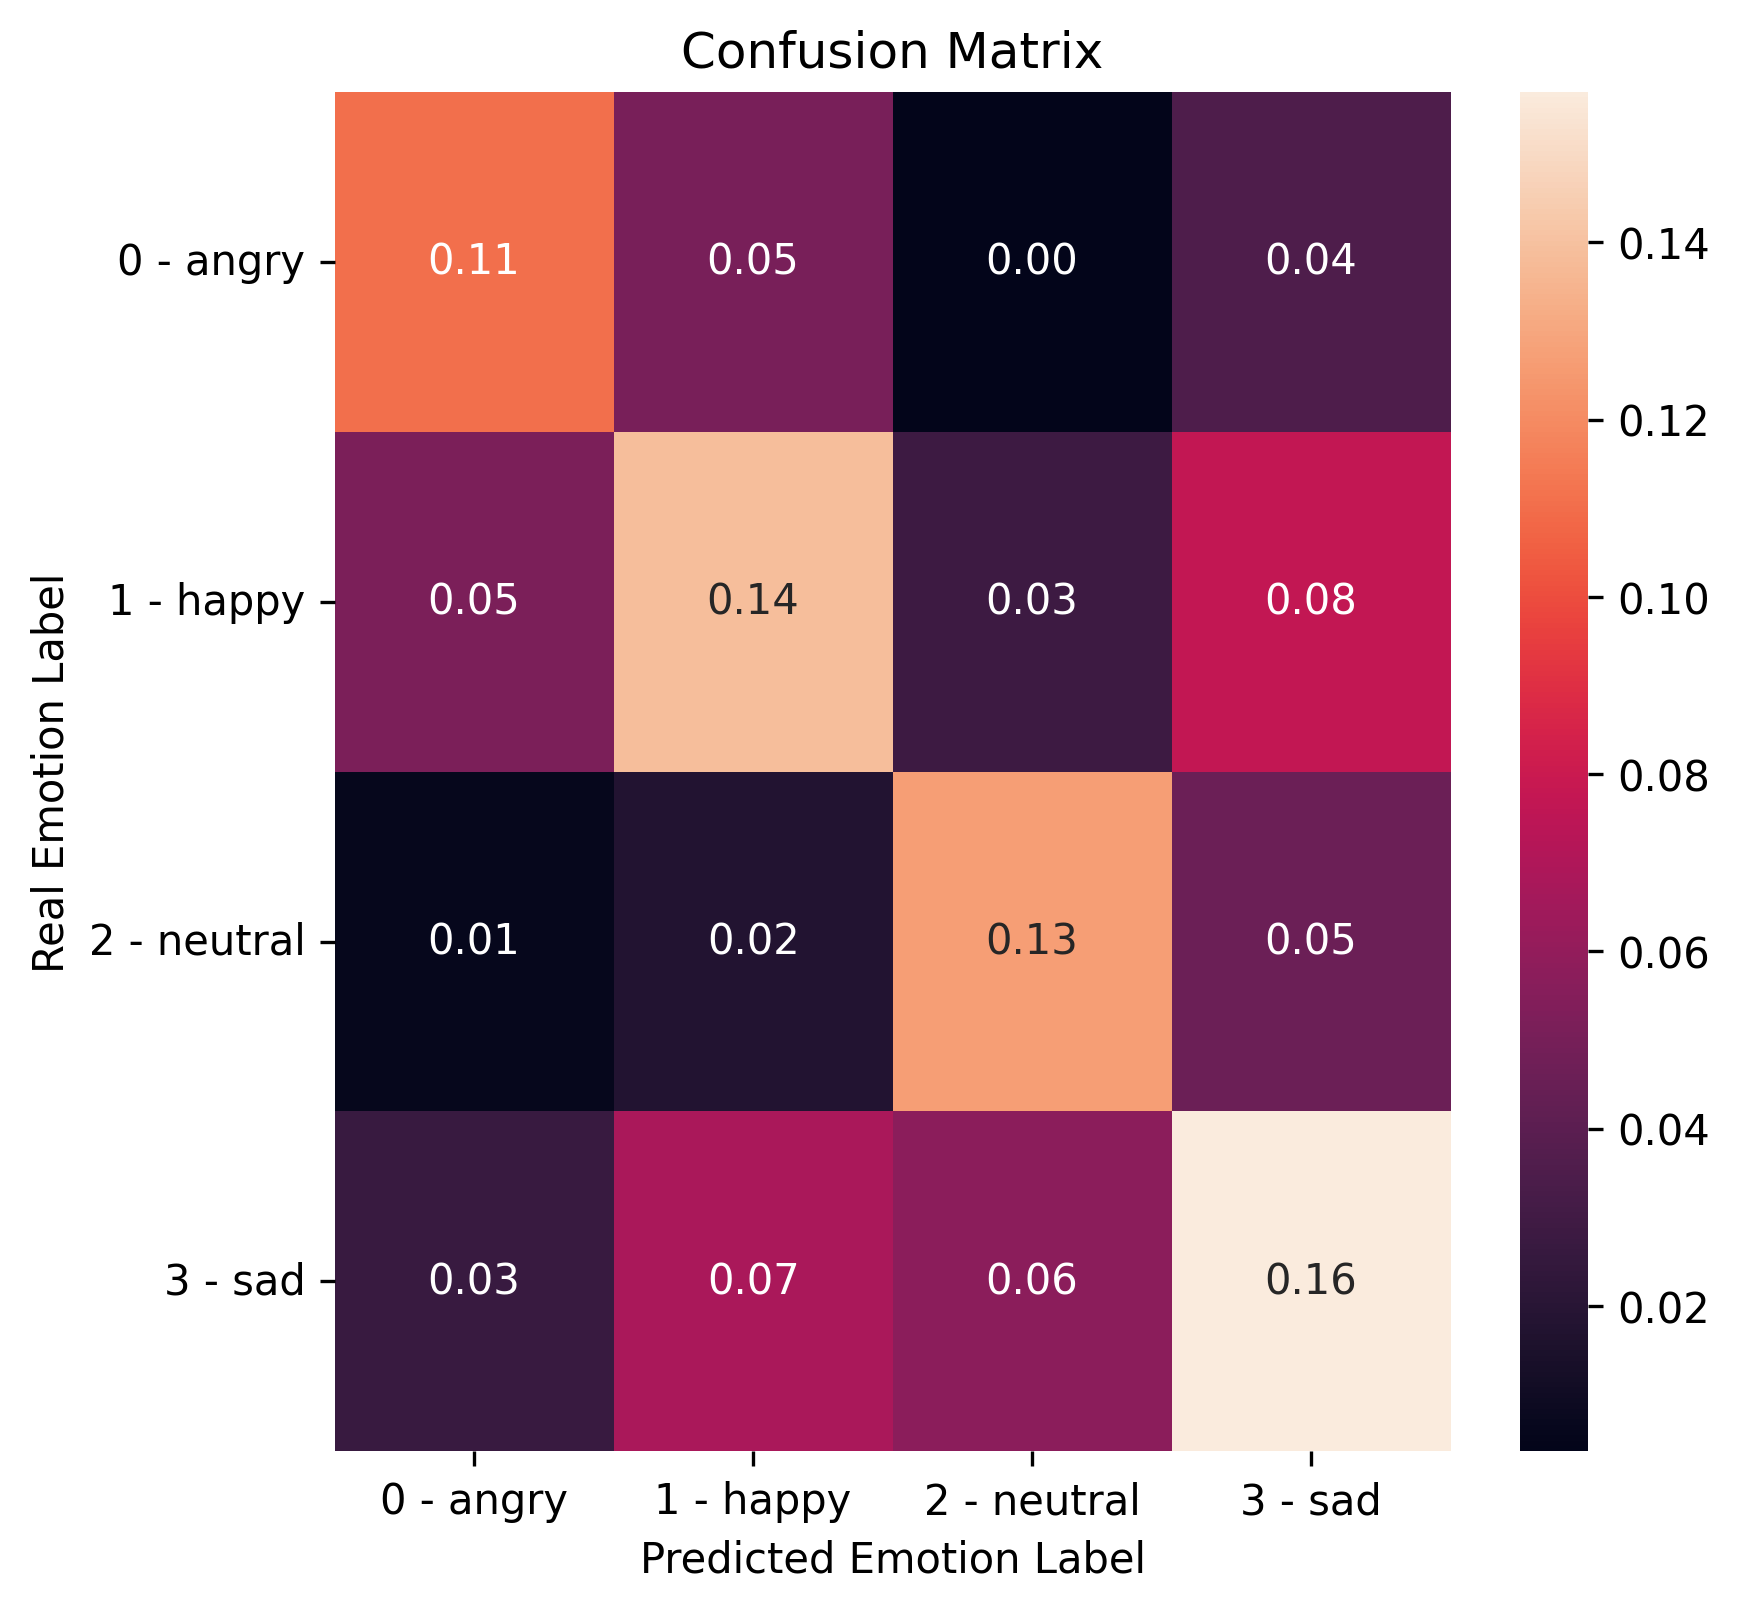

In [17]:
def get_new_model():
    return Ridge(random_state=1)
categorical_cross_validation(get_new_model)

### Gradient Boosting Classifier

Accuracy for fold 0: 57.0%
Accuracy for fold 1: 57.59%
Accuracy for fold 2: 59.76%
Accuracy for fold 3: 59.22%
Accuracy for fold 4: 55.97%

Metric             Value
-----------------  -----------
Accuracy           57.91+-1.4
F1 score macro     58.65
Precision          58.99
Recall             58.53
Matthews corrcoef  0.43
Training Time      21.58+-0.02
Prediction Time    0.03+-0.0

              precision    recall  f1-score   support

           0       0.63      0.59      0.61      1103
           1       0.53      0.48      0.51      1636
           2       0.64      0.65      0.65      1084
           3       0.55      0.62      0.58      1708

    accuracy                           0.58      5531
   macro avg       0.59      0.59      0.59      5531
weighted avg       0.58      0.58      0.58      5531



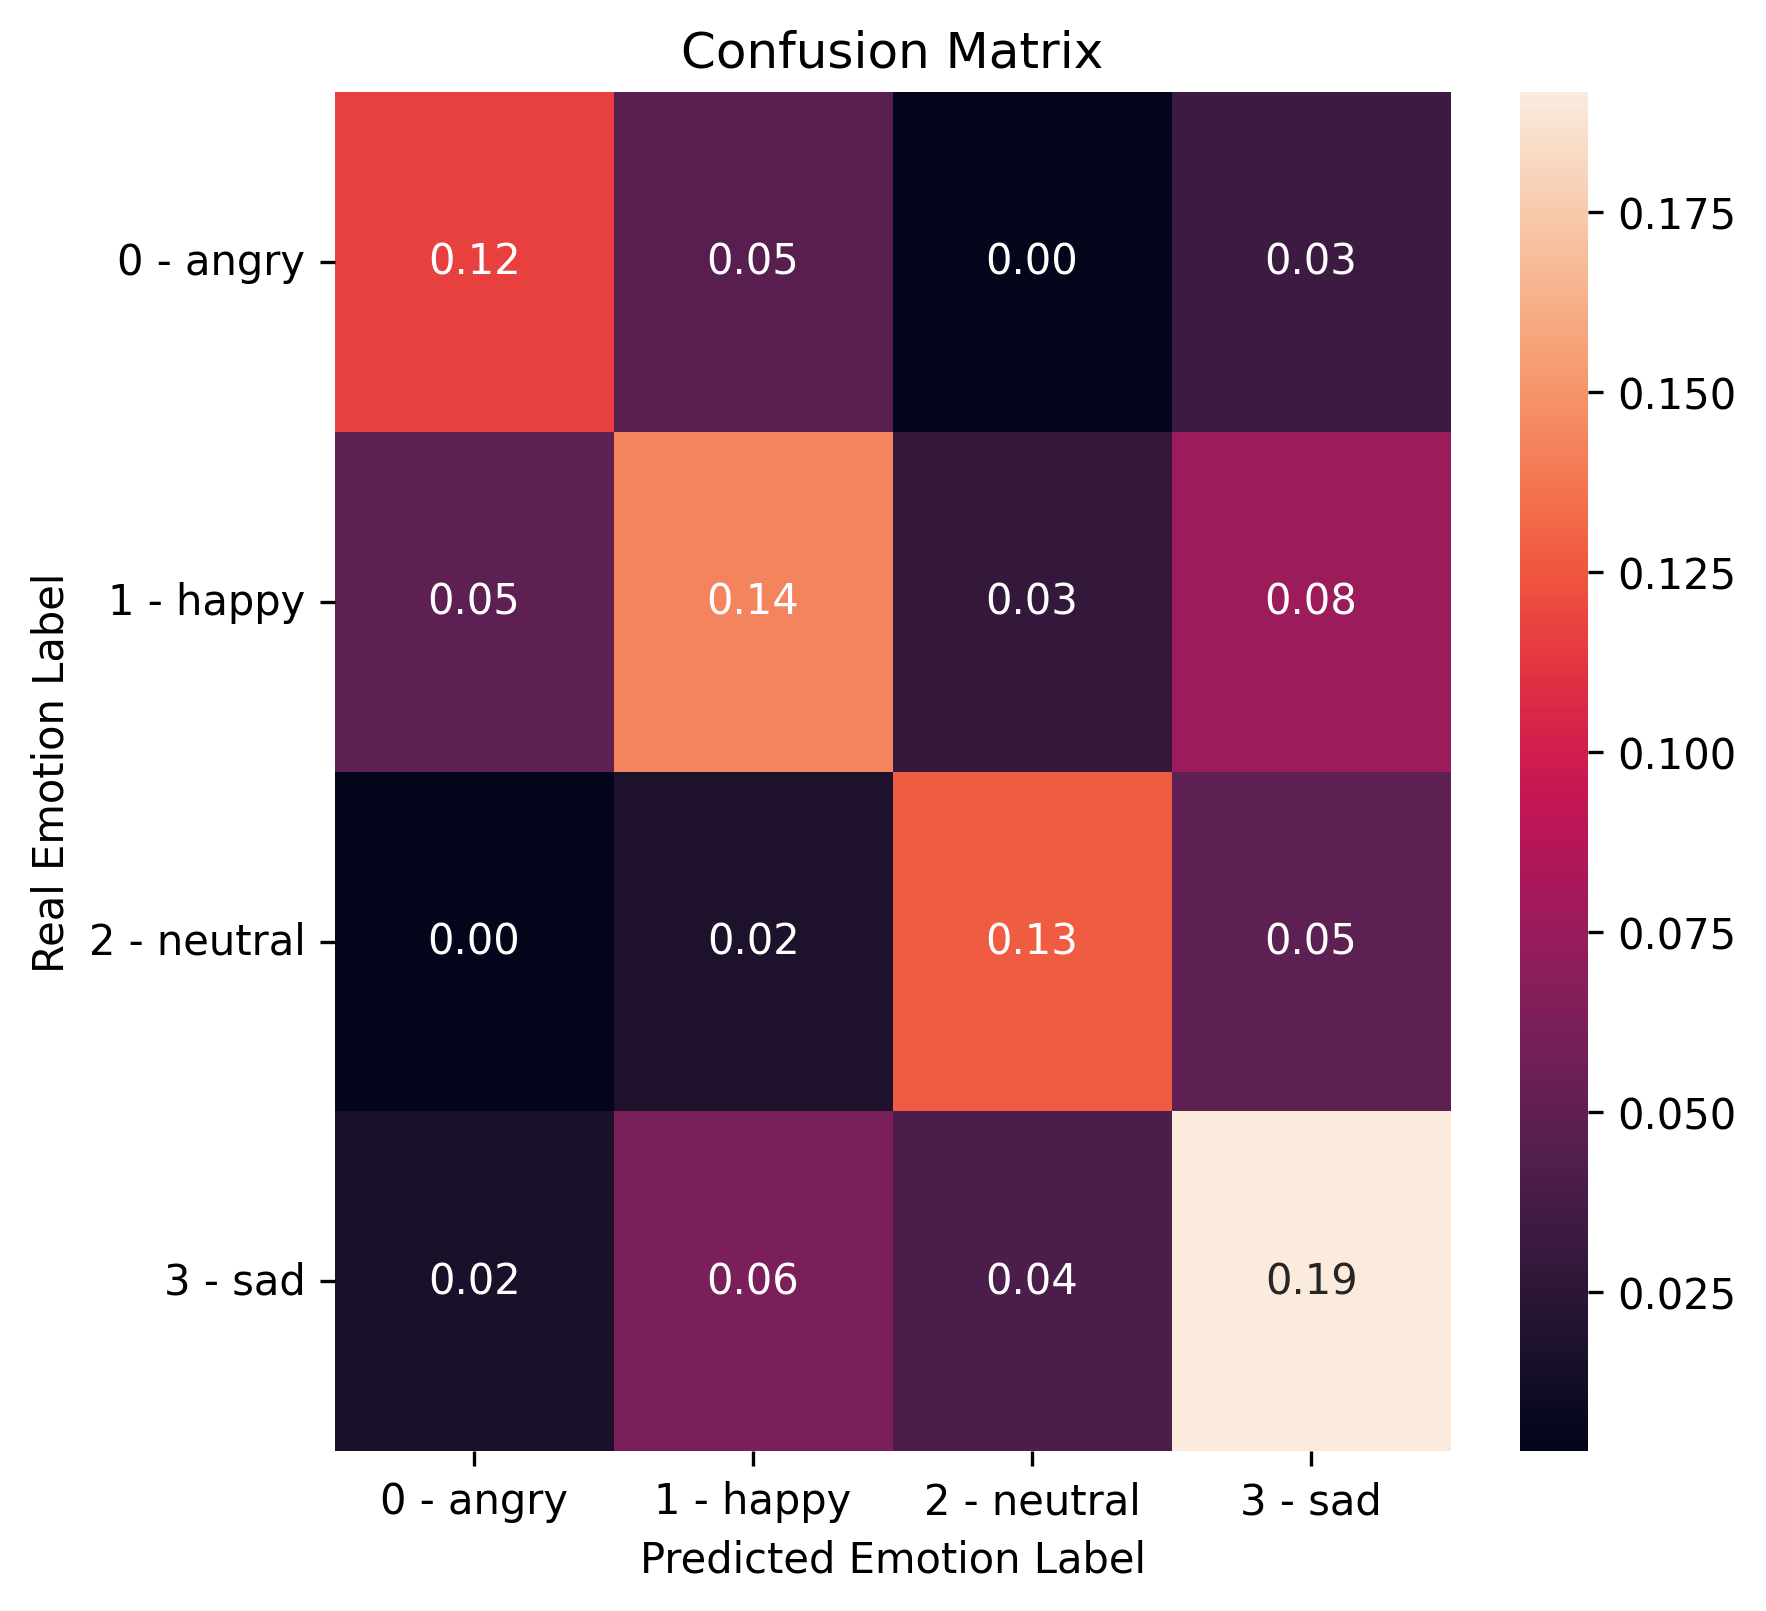

In [18]:
def get_new_model():
    return GradientBoostingClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

### Ada Boost Classifier

Accuracy for fold 0: 58.36%
Accuracy for fold 1: 59.4%
Accuracy for fold 2: 60.94%
Accuracy for fold 3: 60.04%
Accuracy for fold 4: 59.67%

Metric             Value
-----------------  -----------
Accuracy           59.68+-0.84
F1 score macro     60.35
Precision          60.83
Recall             60.26
Matthews corrcoef  0.454
Training Time      8.07+-0.02
Prediction Time    0.38+-0.0

              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1103
           1       0.56      0.49      0.52      1636
           2       0.65      0.67      0.66      1084
           3       0.56      0.65      0.60      1708

    accuracy                           0.60      5531
   macro avg       0.61      0.60      0.60      5531
weighted avg       0.60      0.60      0.60      5531



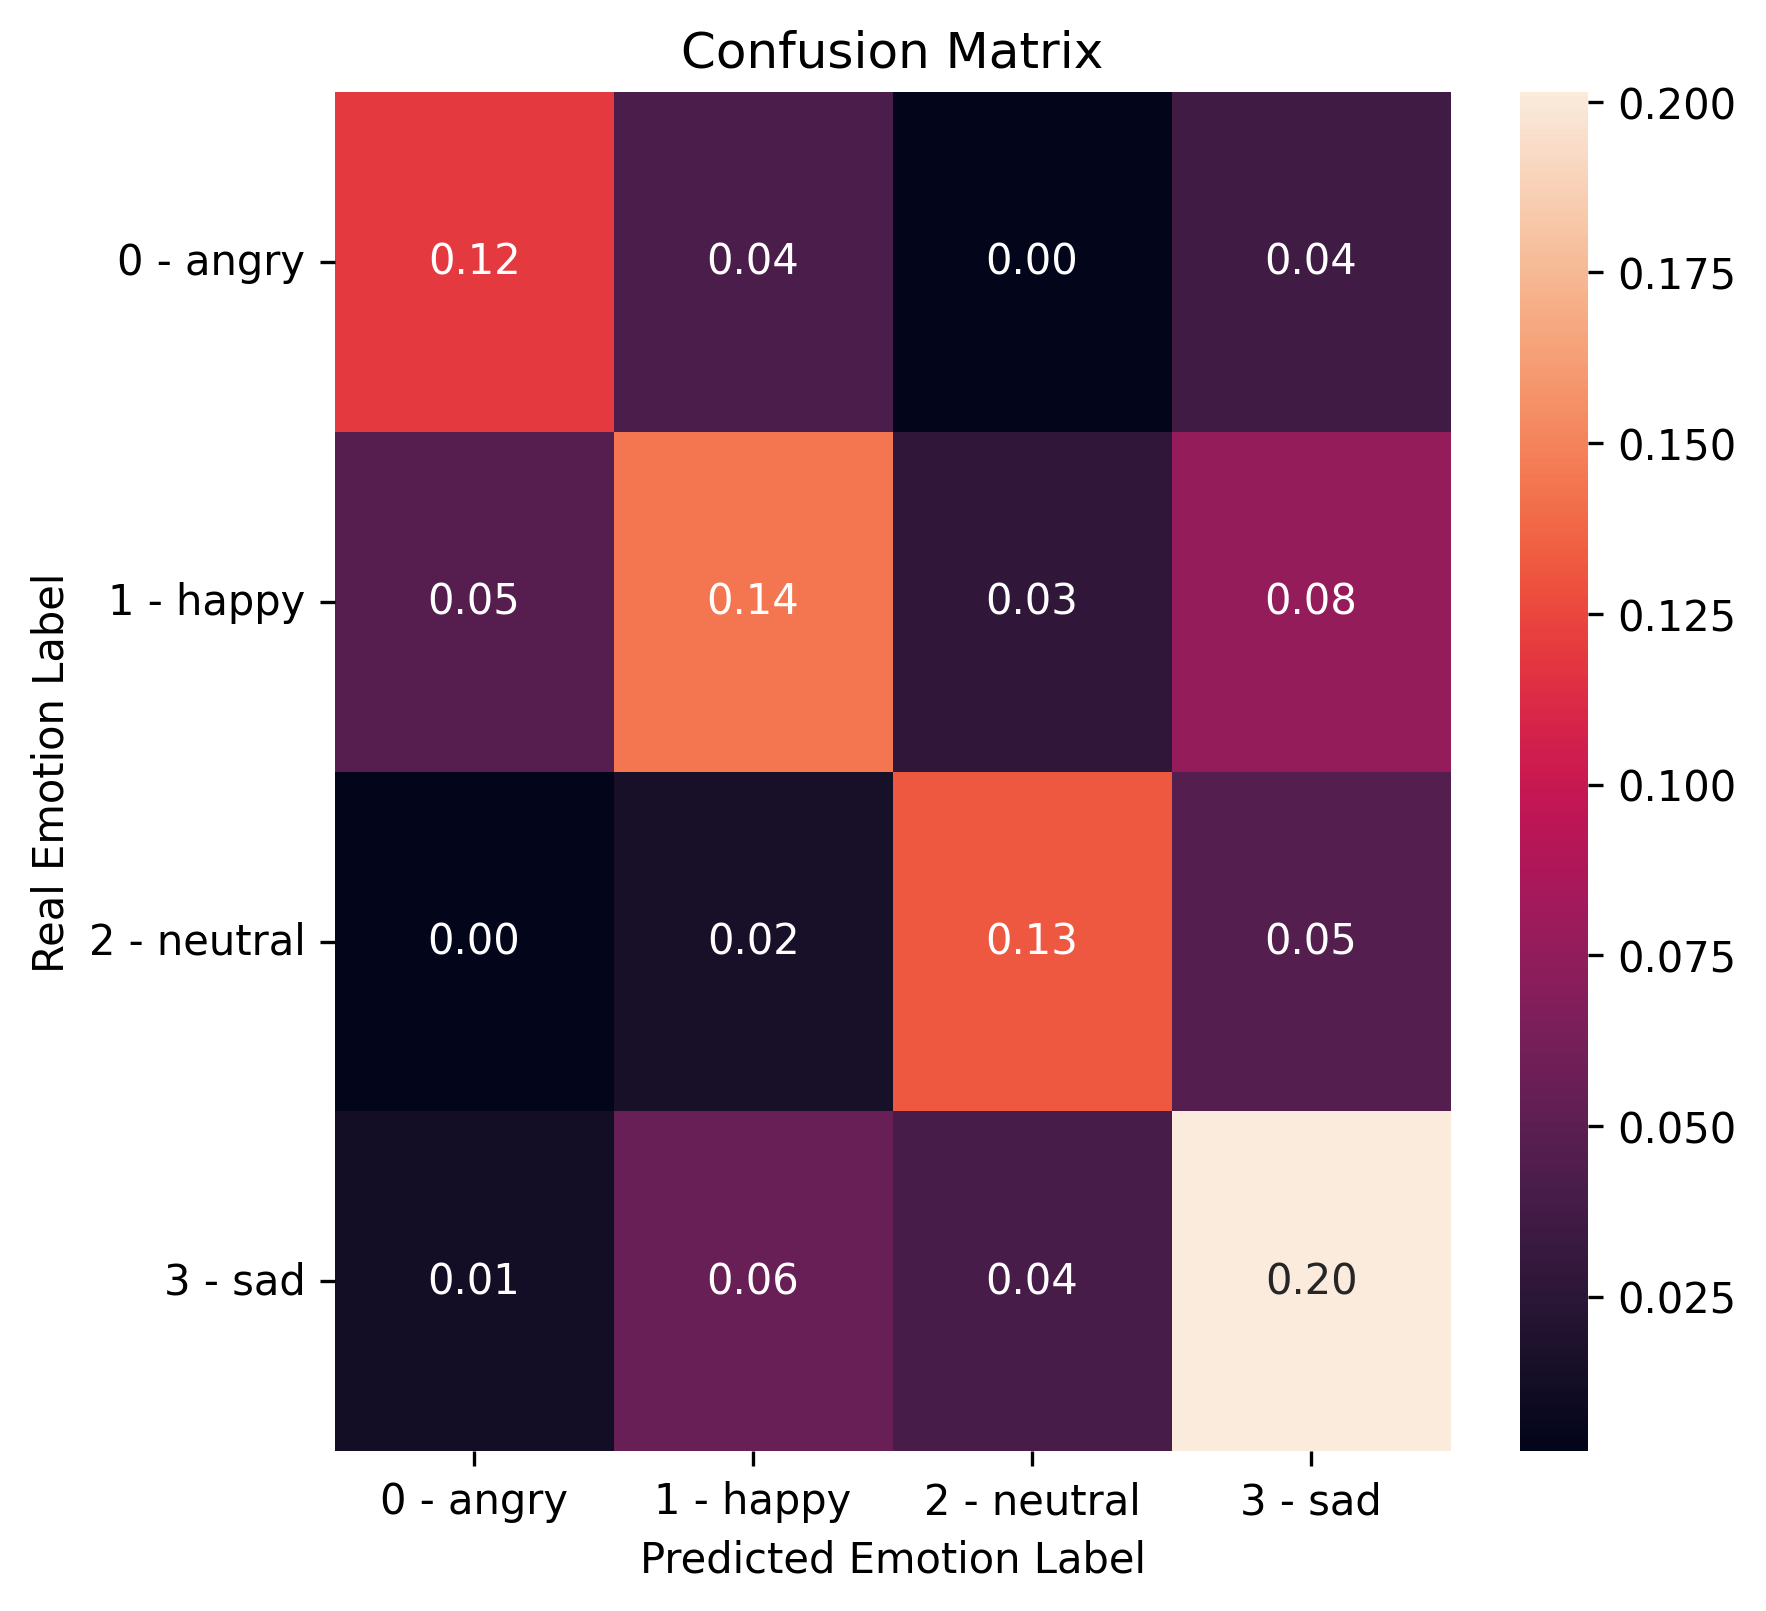

In [19]:
def get_new_model():
    return AdaBoostClassifier(random_state=1, estimator=RandomForest(n_estimators=512, n_jobs=-1, random_state=1))
categorical_cross_validation(get_new_model)


### Balanced Random Forest Classifier

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

Accuracy for fold 0: 55.37%
Accuracy for fold 1: 56.96%
Accuracy for fold 2: 57.41%
Accuracy for fold 3: 57.87%
Accuracy for fold 4: 56.96%

Metric             Value
-----------------  -----------
Accuracy           56.92+-0.84
F1 score macro     57.27
Precision          56.8
Recall             59.67
Matthews corrcoef  0.431
Training Time      11.07+-0.06
Prediction Time    0.11+-0.0

              precision    recall  f1-score   support

           0       0.55      0.71      0.62      1103
           1       0.55      0.38      0.45      1636
           2       0.58      0.75      0.66      1084
           3       0.58      0.54      0.56      1708

    accuracy                           0.57      5531
   macro avg       0.57      0.60      0.57      5531
weighted avg       0.57      0.57      0.56      5531



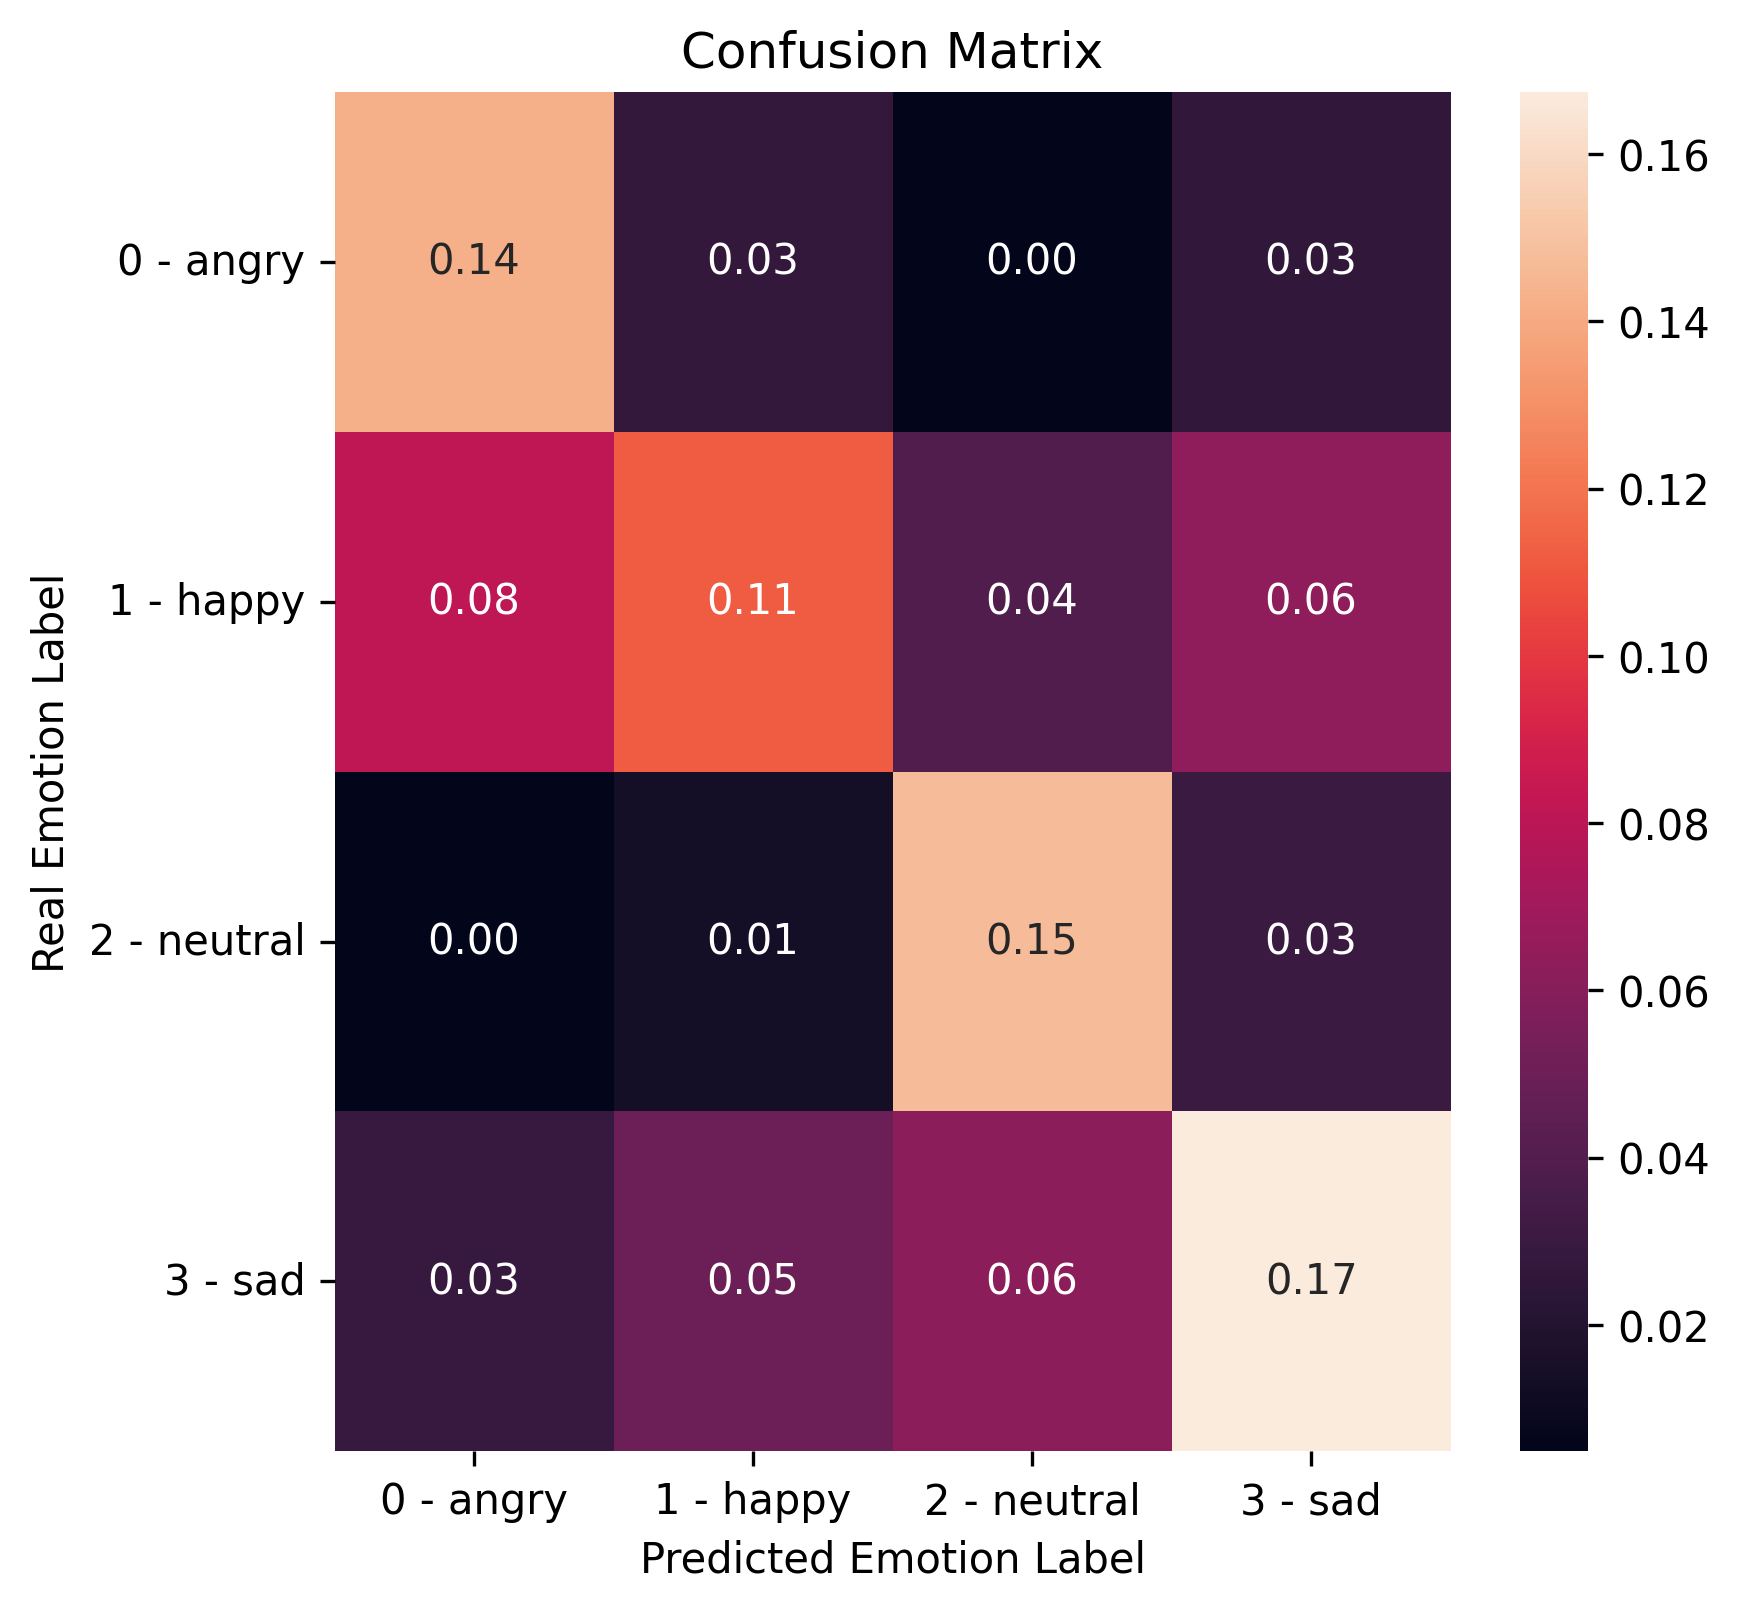

In [20]:
def get_new_model():
    return BalancedRandomForestClassifier(random_state=1, max_features=8)
categorical_cross_validation(get_new_model)

### AutoSKlearn

#### Testing the Highest Ranked Models of the Ensemble

Accuracy for fold 0: 58.54%
Accuracy for fold 1: 60.04%
Accuracy for fold 2: 60.13%
Accuracy for fold 3: 59.22%
Accuracy for fold 4: 58.14%

Metric             Value
-----------------  -----------
Accuracy           59.21+-0.79
F1 score macro     59.85
Precision          60.43
Recall             59.66
Matthews corrcoef  0.447
Training Time      6.78+-0.06
Prediction Time    0.44+-0.01

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      1103
           1       0.55      0.49      0.52      1636
           2       0.65      0.66      0.66      1084
           3       0.56      0.65      0.60      1708

    accuracy                           0.59      5531
   macro avg       0.60      0.60      0.60      5531
weighted avg       0.59      0.59      0.59      5531



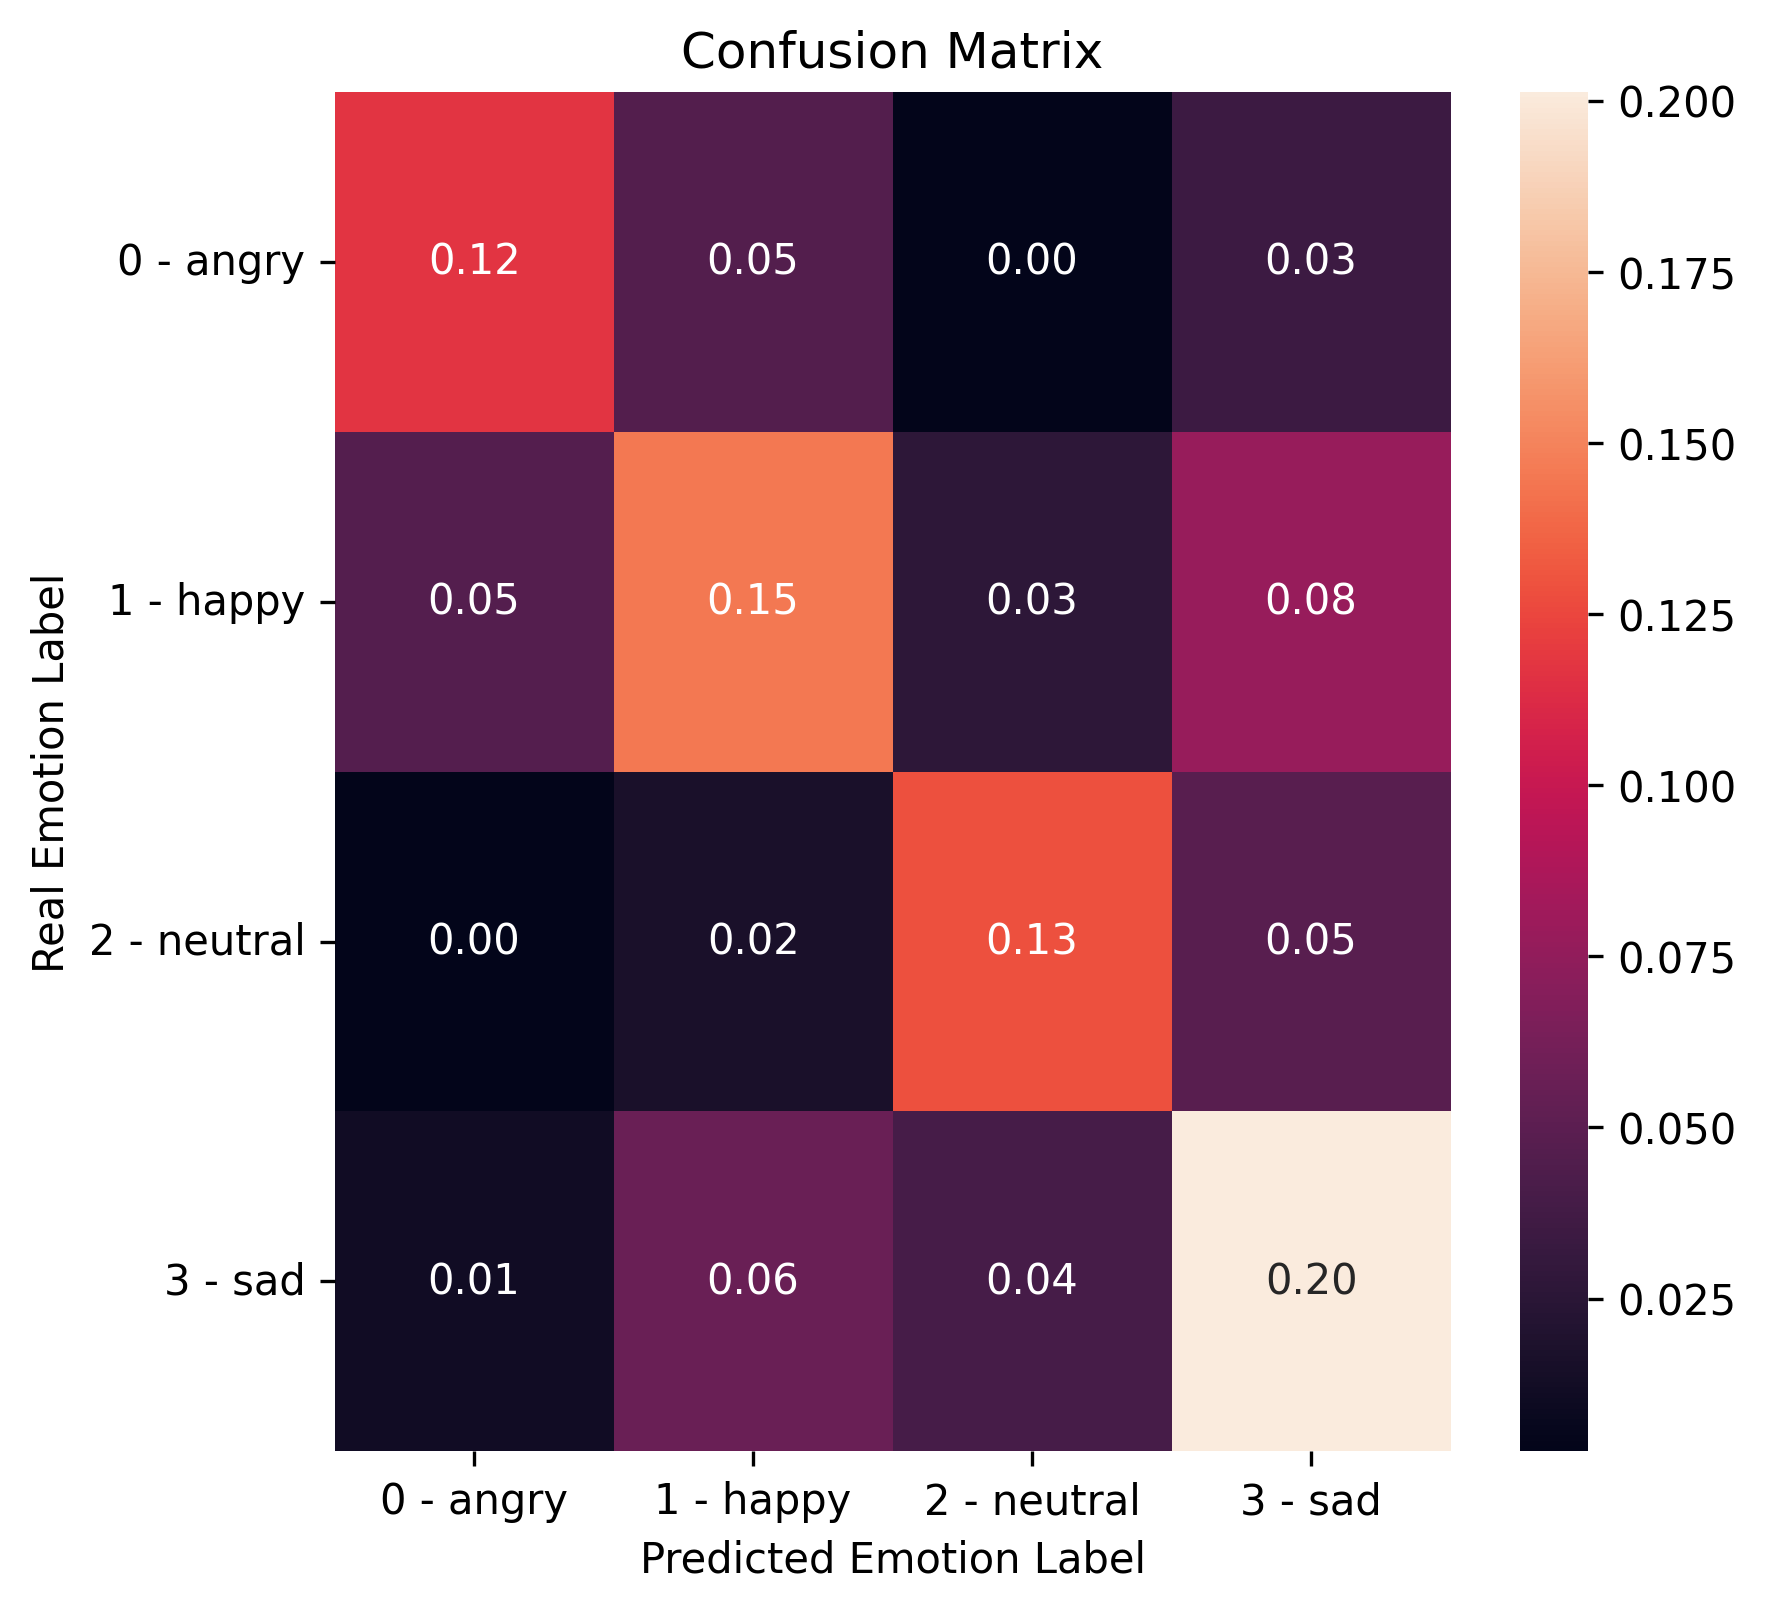

In [22]:
def get_new_model():
  return RandomForest(max_features=4, n_estimators=512, n_jobs=-1,
                       random_state=1, warm_start=True)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 52.57%
Accuracy for fold 1: 52.17%
Accuracy for fold 2: 55.24%
Accuracy for fold 3: 54.79%
Accuracy for fold 4: 55.42%

Metric             Value
-----------------  -----------
Accuracy           54.04+-1.38
F1 score macro     55.06
Precision          55.01
Recall             55.23
Matthews corrcoef  0.379
Training Time      0.06+-0.0
Prediction Time    0.01+-0.0

              precision    recall  f1-score   support

           0       0.60      0.56      0.58      1103
           1       0.49      0.48      0.49      1636
           2       0.60      0.66      0.63      1084
           3       0.51      0.51      0.51      1708

    accuracy                           0.54      5531
   macro avg       0.55      0.55      0.55      5531
weighted avg       0.54      0.54      0.54      5531



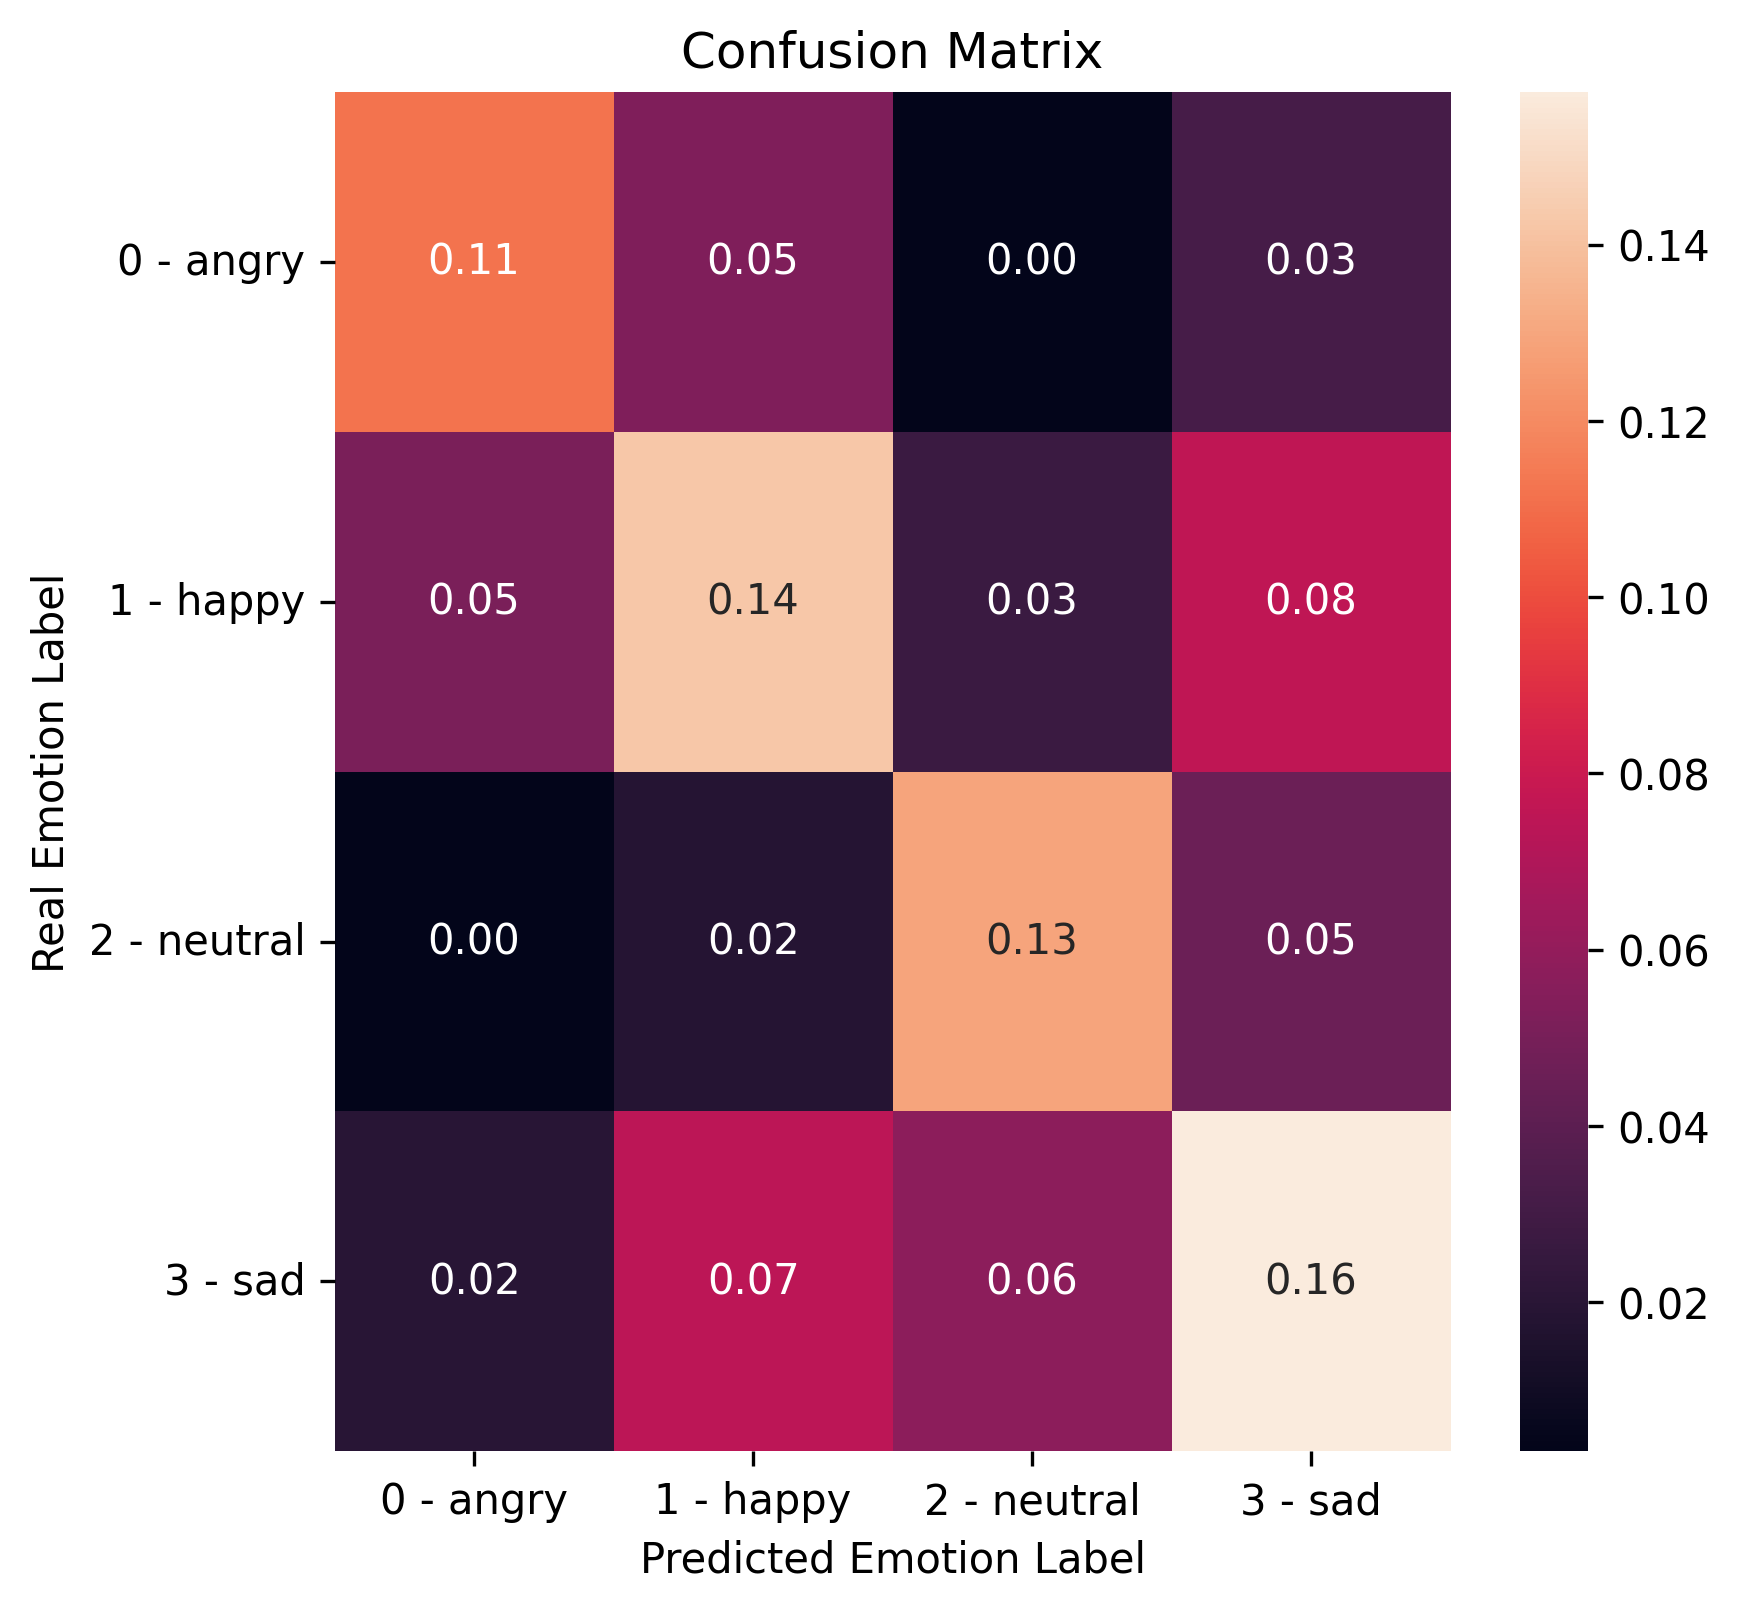

In [21]:
def get_new_model():
    return LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr',
                           tol=0.00010000000000000009)
categorical_cross_validation(get_new_model)

Accuracy for fold 0: 57.81%
Accuracy for fold 1: 58.77%
Accuracy for fold 2: 61.93%
Accuracy for fold 3: 59.86%
Accuracy for fold 4: 57.87%

Metric             Value
-----------------  -------------
Accuracy           59.25+-1.53
F1 score macro     59.8
Precision          60.34
Recall             59.47
Matthews corrcoef  0.447
Training Time      133.31+-12.83
Prediction Time    0.55+-0.1

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1103
           1       0.56      0.53      0.54      1636
           2       0.66      0.64      0.65      1084
           3       0.56      0.64      0.60      1708

    accuracy                           0.59      5531
   macro avg       0.60      0.59      0.60      5531
weighted avg       0.59      0.59      0.59      5531



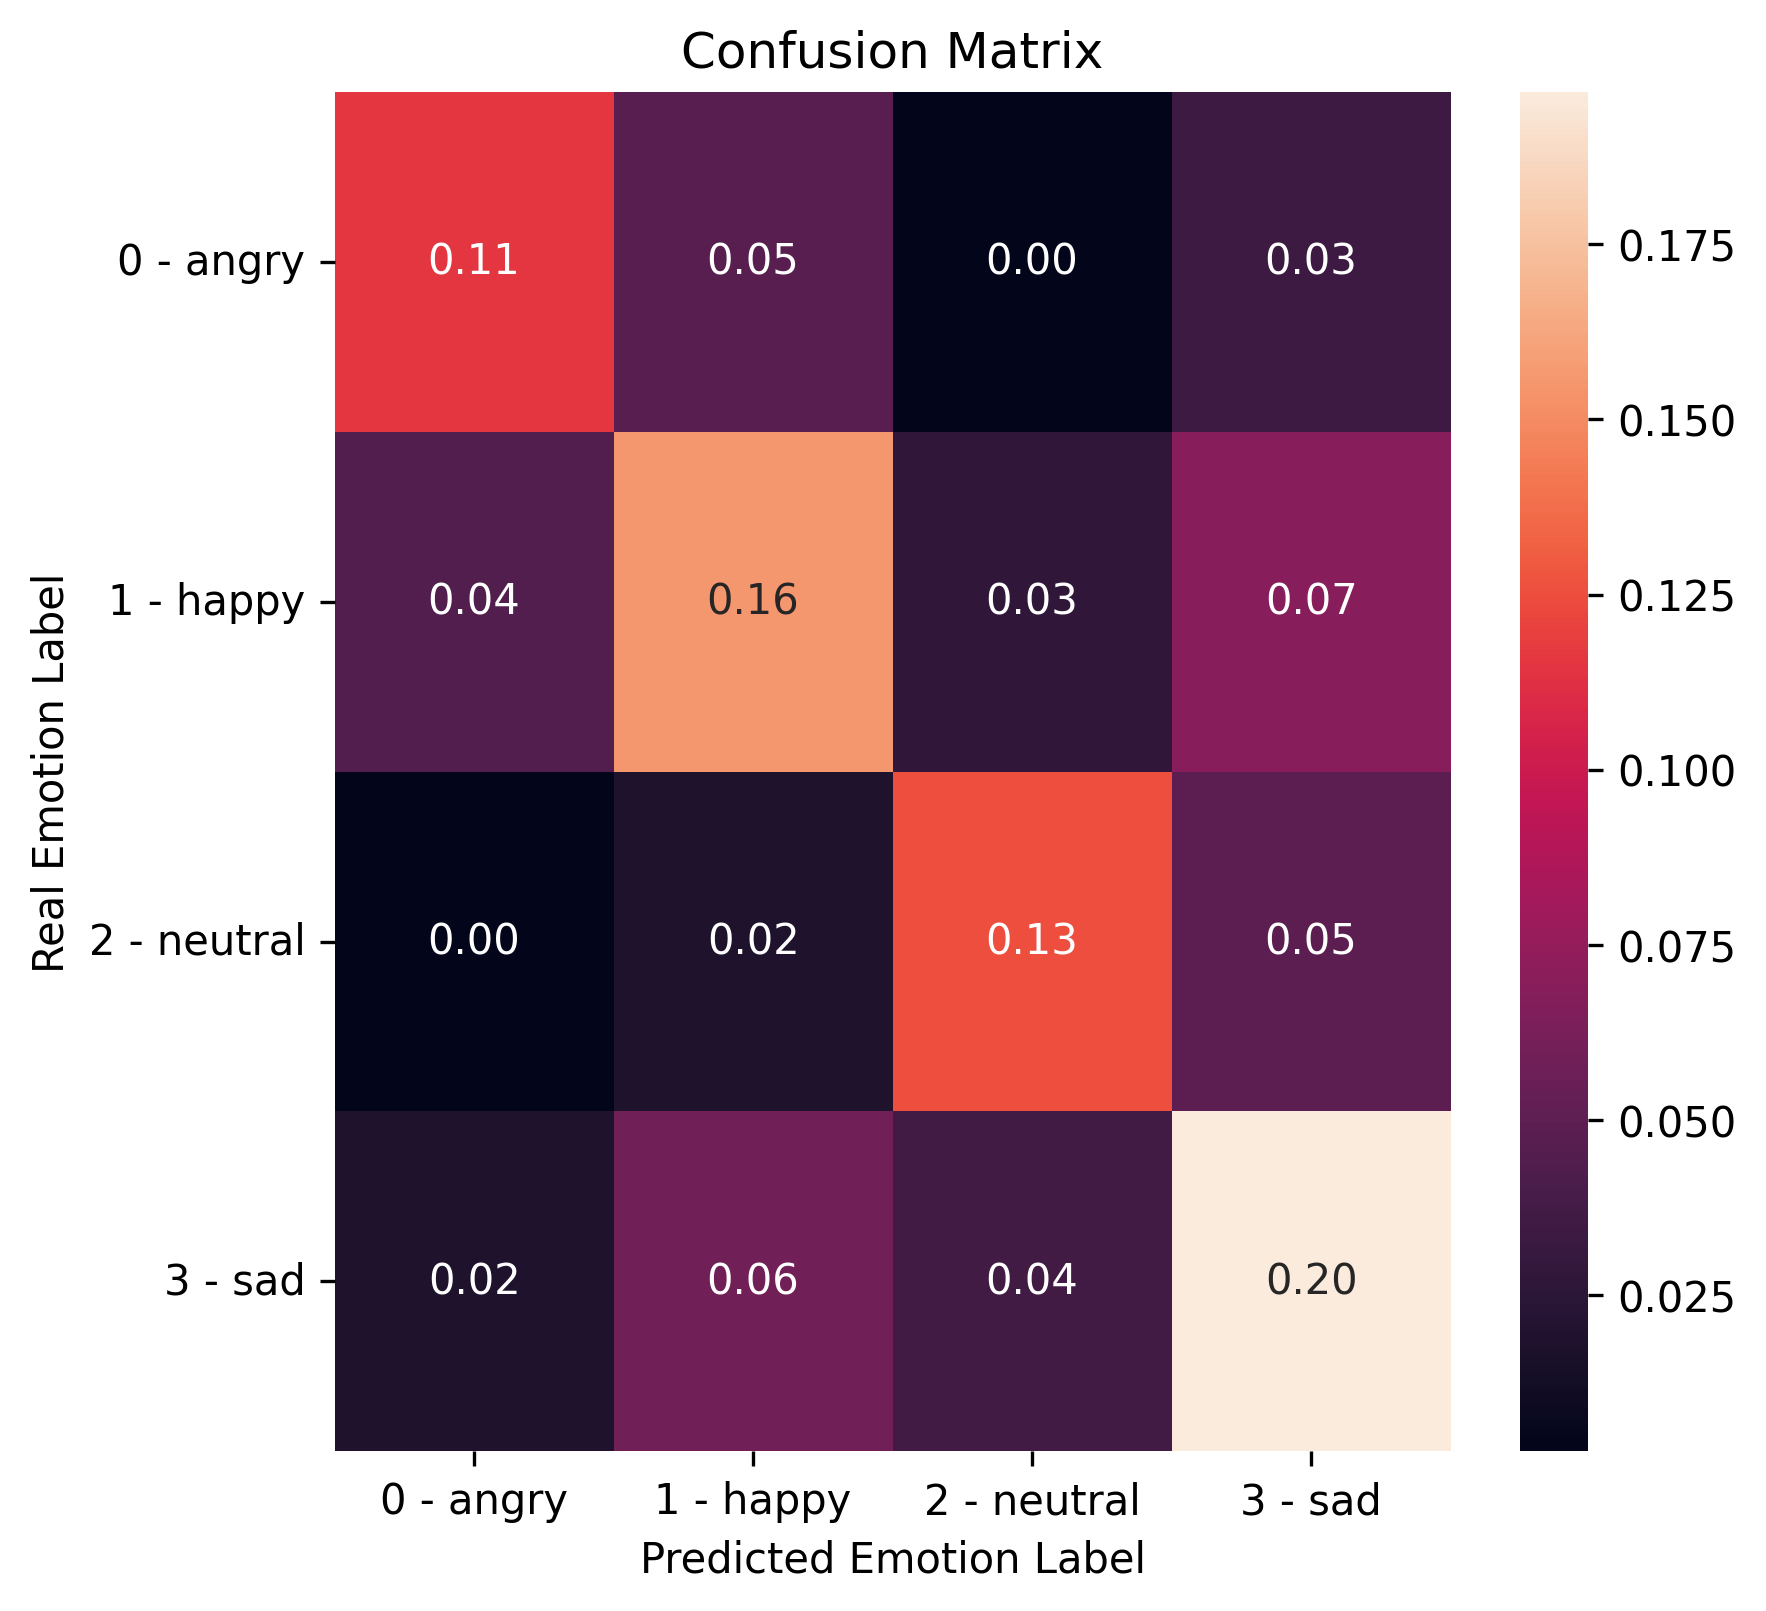

In [23]:
def get_new_model():
    return HistGradientBoostingClassifier(early_stopping=False,
                                          l2_regularization=2.188553300996835e-10,
                                          learning_rate=0.06138190336151616, max_iter=512,
                                          max_leaf_nodes=20, n_iter_no_change=17,
                                          random_state=1, validation_fraction=None,
                                          warm_start=True)
categorical_cross_validation(get_new_model)

### SOA CNN - https://www.sciencedirect.com/science/article/pii/S1746809420300501?via=ihub

In [45]:
def build_model_soa(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv1D(128, 5, strides=1, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(128, 5, strides=1))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    # model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=5))
    # model.add(Conv1D(128, 5, strides=1))
    # model.add(Activation('relu'))
    # model.add(Conv1D(128, 5, strides=1))
    # model.add(Activation('relu'))
    model.add(Conv1D(64, 5, strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dropout(0.15))
    model.add(Dense(4))
    # model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model(input_shape=(35, 1)):
    learning_rate = 1e-5
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_soa(input_shape, loss, optimizer)

get_new_model(input_shape=(35,1)).summary(show_trainable=True)

Model: "sequential_41"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d_119 (Conv1D)         (None, 31, 128)           768       Y          
                                                                            
 batch_normalization_73 (Bat  (None, 31, 128)          512       Y          
 chNormalization)                                                           
                                                                            
 activation_146 (Activation)  (None, 31, 128)          0         Y          
                                                                            
 conv1d_120 (Conv1D)         (None, 27, 128)           82048     Y          
                                                                            
 activation_147 (Activation)  (None, 27, 128)          0         Y          
                                                     

In [46]:
def categorical_cross_validation(get_new_model, callbacks, no_epochs, batch_size, verbosity=1, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
    
  X = df.iloc[:, 9:]
  y = df.iloc[:, 5:6]

  all_y_pred = []
  all_y_labels = []

  training_times = []
  prediction_times = []
  folds_size = []

  for train, test in kfold.split(X, y):
    model = get_new_model()

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    folds_size.append(len(y_test))

    start_time = time.time()
    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              workers=-1)
    training_times.append(time.time() - start_time)

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_times.append(time.time() - start_time)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred, folds_size, training_times, prediction_times

no_epochs = 500
batch_size = 32

verbosity = 1
num_folds = 5


all_y_labels, all_y_pred, folds_size, training_times, prediction_times = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Epoch 1/500
139/139 [==============================] - 1s 7ms/step - loss: 1.6155 - accuracy: 0.2342 - val_loss: 1.4203 - val_accuracy: 0.1752
Epoch 2/500
139/139 [==============================] - 1s 6ms/step - loss: 1.5899 - accuracy: 0.2505 - val_loss: 1.4135 - val_accuracy: 0.2276
Epoch 3/500
139/139 [==============================] - 1s 6ms/step - loss: 1.5648 - accuracy: 0.2633 - val_loss: 1.4261 - val_accuracy: 0.2782
Epoch 4/500
139/139 [==============================] - 1s 6ms/step - loss: 1.5267 - accuracy: 0.2758 - val_loss: 1.3930 - val_accuracy: 0.2746
Epoch 5/500
139/139 [==============================] - 1s 6ms/step - loss: 1.5327 - accuracy: 0.2751 - val_loss: 1.4123 - val_accuracy: 0.2800
Epoch 6/500
139/139 [==============================] - 1s 6ms/step - loss: 1.5206 - accuracy: 0.2717 - val_loss: 1.3669 - val_accuracy: 0.2954
Epoch 7/500
139/139 [==============================] - 1s 6ms/step - loss: 1.5137 - accuracy: 0.2674 - val_loss: 1.3697 - val_accuracy: 0.2981

Accuracy for fold 0: 31.71%
Accuracy for fold 1: 37.88%
Accuracy for fold 2: 23.33%
Accuracy for fold 3: 26.76%
Accuracy for fold 4: 36.89%

Metric             Value
-----------------  -------------
Accuracy           31.31+-5.64
F1 score macro     25.04
Precision          44.4
Recall             34.27
Matthews corrcoef  0.135
Training Time      2128.11+-6.01
Prediction Time    0.81+-0.01

              precision    recall  f1-score   support

           0       0.65      0.08      0.14      1103
           1       0.49      0.05      0.09      1636
           2       0.27      0.89      0.41      1084
           3       0.37      0.35      0.36      1708

    accuracy                           0.31      5531
   macro avg       0.44      0.34      0.25      5531
weighted avg       0.44      0.31      0.25      5531



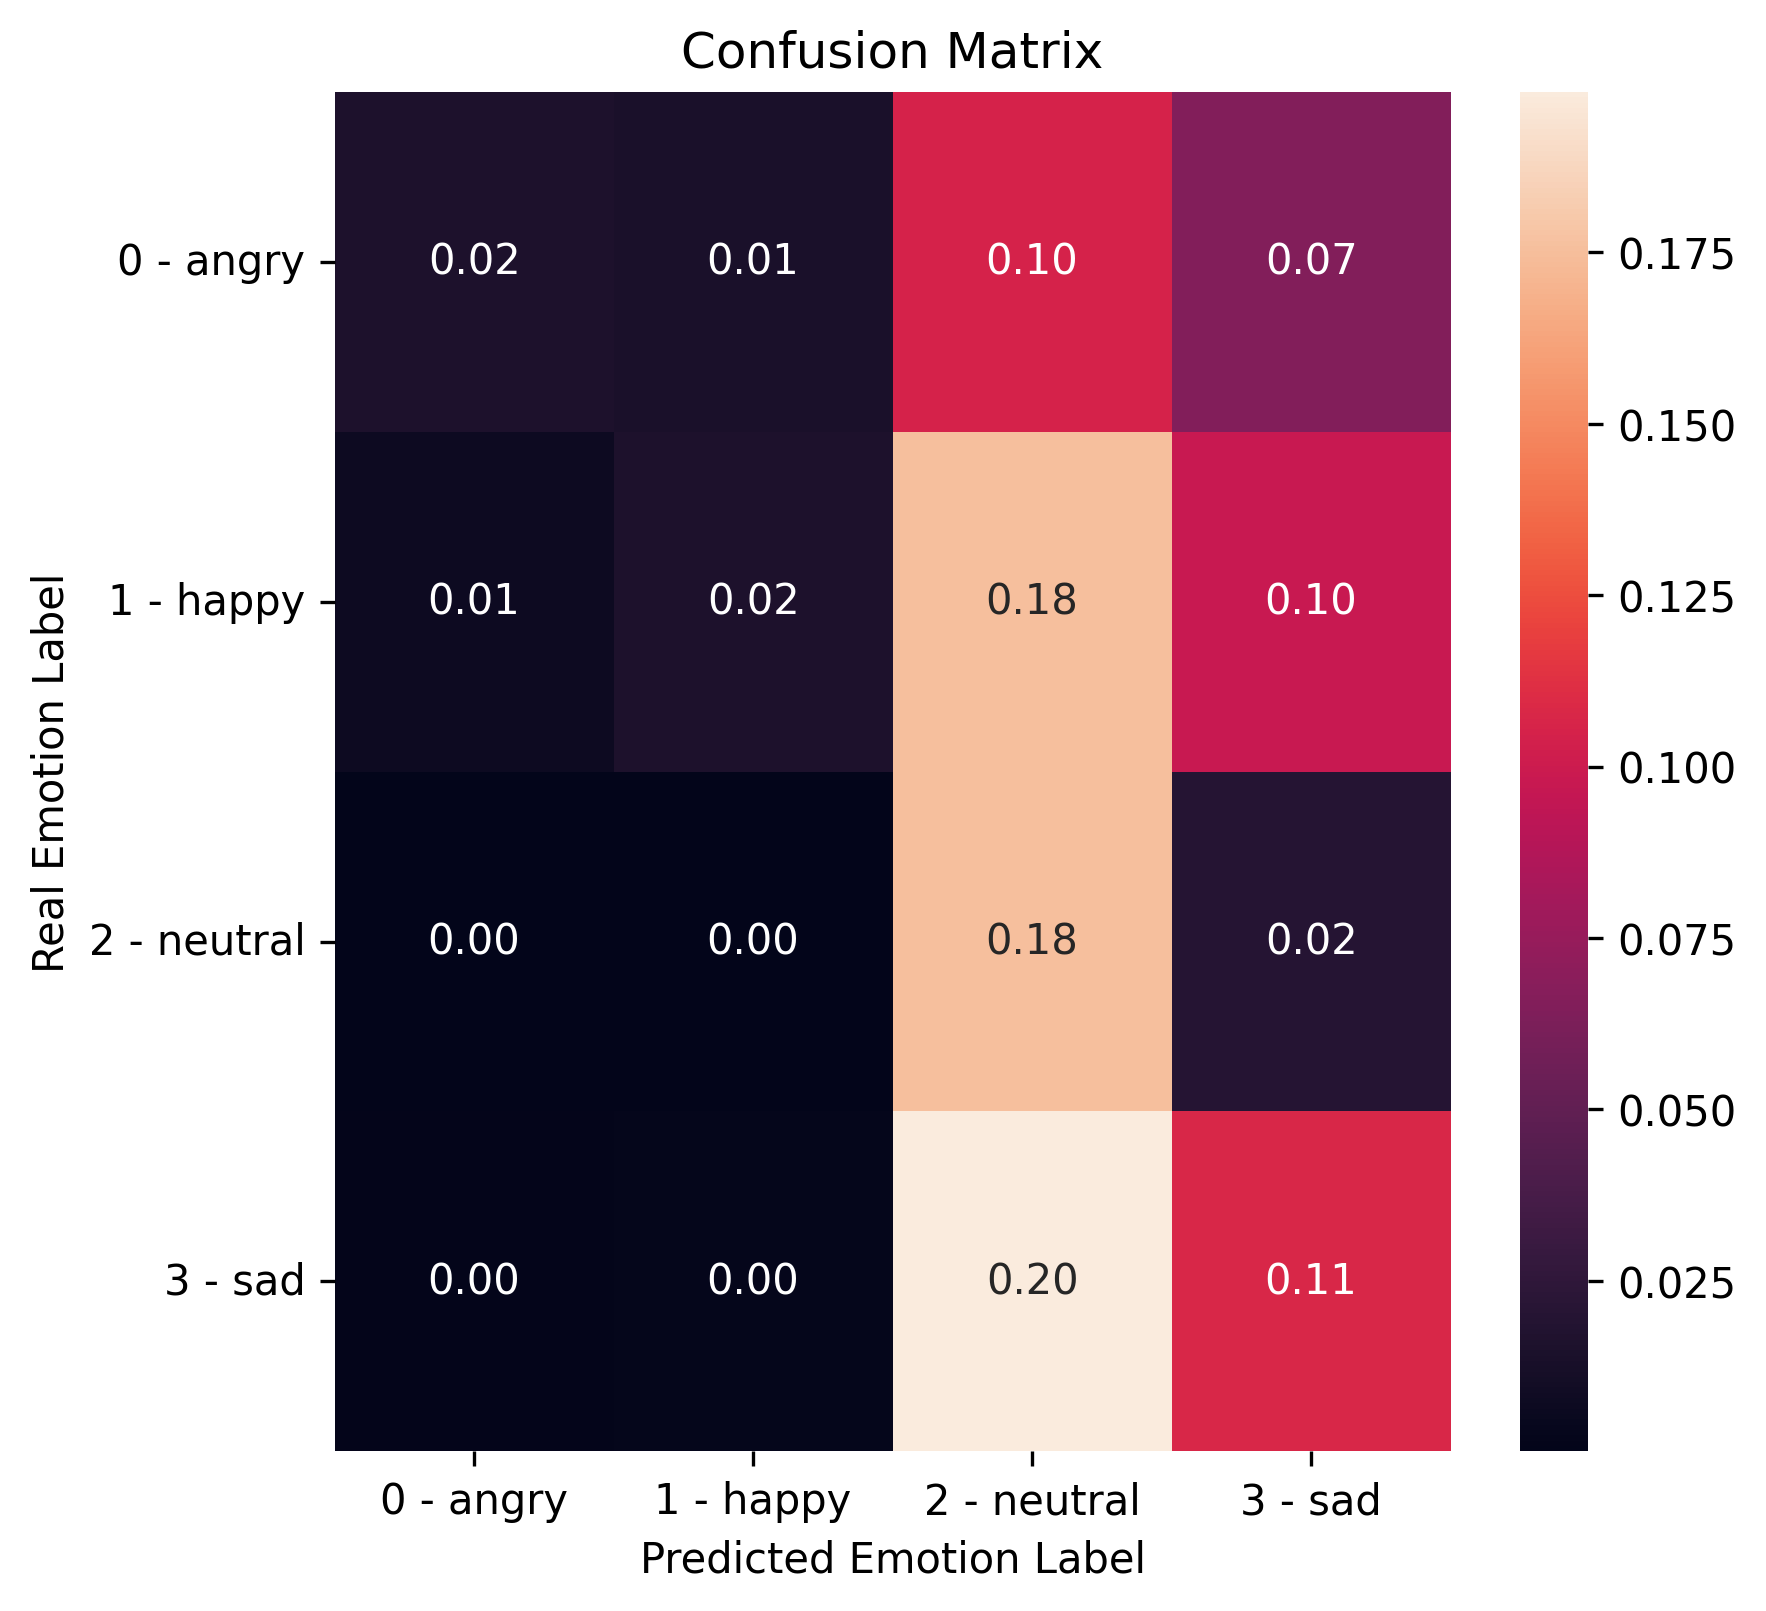

In [47]:
get_metrics(all_y_labels, all_y_pred, folds_size, training_times, prediction_times)

In [24]:
def build_model_0(input_shape=(33, 1), loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
        activation = 'softmax'
    else:
        n_labels = 3
        metrics = ['mae']
        activation = 'relu'

    model = Sequential()
    model.add(Conv1D(128, (5), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(64, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(32, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_0(input_shape=(33,1)).summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 29, 128)           768       Y          
                                                                            
 activation (Activation)     (None, 29, 128)           0         Y          
                                                                            
 batch_normalization (BatchN  (None, 29, 128)          512       Y          
 ormalization)                                                              
                                                                            
 dropout (Dropout)           (None, 29, 128)           0         Y          
                                                                            
 conv1d_1 (Conv1D)           (None, 25, 64)            41024     Y          
                                                        

In [25]:
def categorical_cross_validation(get_new_model, callbacks, no_epochs, batch_size, verbosity=1, num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
    
  X = df.iloc[:, 9:]
  y = df.iloc[:, 5:6]

  all_y_pred = []
  all_y_labels = []

  training_times = []
  prediction_times = []
  folds_size = []

  for train, test in kfold.split(X, y):
    model = get_new_model()

    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    folds_size.append(len(y_test))

    start_time = time.time()
    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=callbacks,
              workers=-1)
    training_times.append(time.time() - start_time)

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_times.append(time.time() - start_time)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred, folds_size, training_times, prediction_times

callback = EarlyStopping(monitor='val_loss', patience=10)
no_epochs = 150
batch_size = 16

verbosity = 1
num_folds = 5


def get_new_model():
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_0(input_shape=(33, 1), loss=loss, optimizer=optimizer)


all_y_labels, all_y_pred, folds_size, training_times, prediction_times = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Epoch 1/150
277/277 [==============================] - 2s 5ms/step - loss: 1.3866 - accuracy: 0.3906 - val_loss: 1.1815 - val_accuracy: 0.4643
Epoch 2/150
277/277 [==============================] - 1s 5ms/step - loss: 1.2506 - accuracy: 0.4091 - val_loss: 1.1685 - val_accuracy: 0.4679
Epoch 3/150
277/277 [==============================] - 1s 4ms/step - loss: 1.2285 - accuracy: 0.4134 - val_loss: 1.1818 - val_accuracy: 0.4228
Epoch 4/150
277/277 [==============================] - 1s 4ms/step - loss: 1.1838 - accuracy: 0.4417 - val_loss: 1.1373 - val_accuracy: 0.4824
Epoch 5/150
277/277 [==============================] - 1s 4ms/step - loss: 1.1752 - accuracy: 0.4329 - val_loss: 1.1474 - val_accuracy: 0.4670
Epoch 6/150
277/277 [==============================] - 1s 5ms/step - loss: 1.1603 - accuracy: 0.4496 - val_loss: 1.1509 - val_accuracy: 0.4481
Epoch 7/150
277/277 [==============================] - 1s 5ms/step - loss: 1.1687 - accuracy: 0.4421 - val_loss: 1.1517 - val_accuracy: 0.4535

Accuracy for fold 0: 50.77%
Accuracy for fold 1: 49.55%
Accuracy for fold 2: 50.9%
Accuracy for fold 3: 51.72%
Accuracy for fold 4: 49.1%

Metric             Value
-----------------  -------------
Accuracy           50.41+-0.95
F1 score macro     51.25
Precision          51.61
Recall             52.69
Matthews corrcoef  0.34
Training Time      340.74+-12.66
Prediction Time    0.81+-0.01

              precision    recall  f1-score   support

           0       0.48      0.73      0.58      1103
           1       0.47      0.42      0.44      1636
           2       0.62      0.54      0.58      1084
           3       0.50      0.41      0.45      1708

    accuracy                           0.50      5531
   macro avg       0.52      0.53      0.51      5531
weighted avg       0.51      0.50      0.50      5531



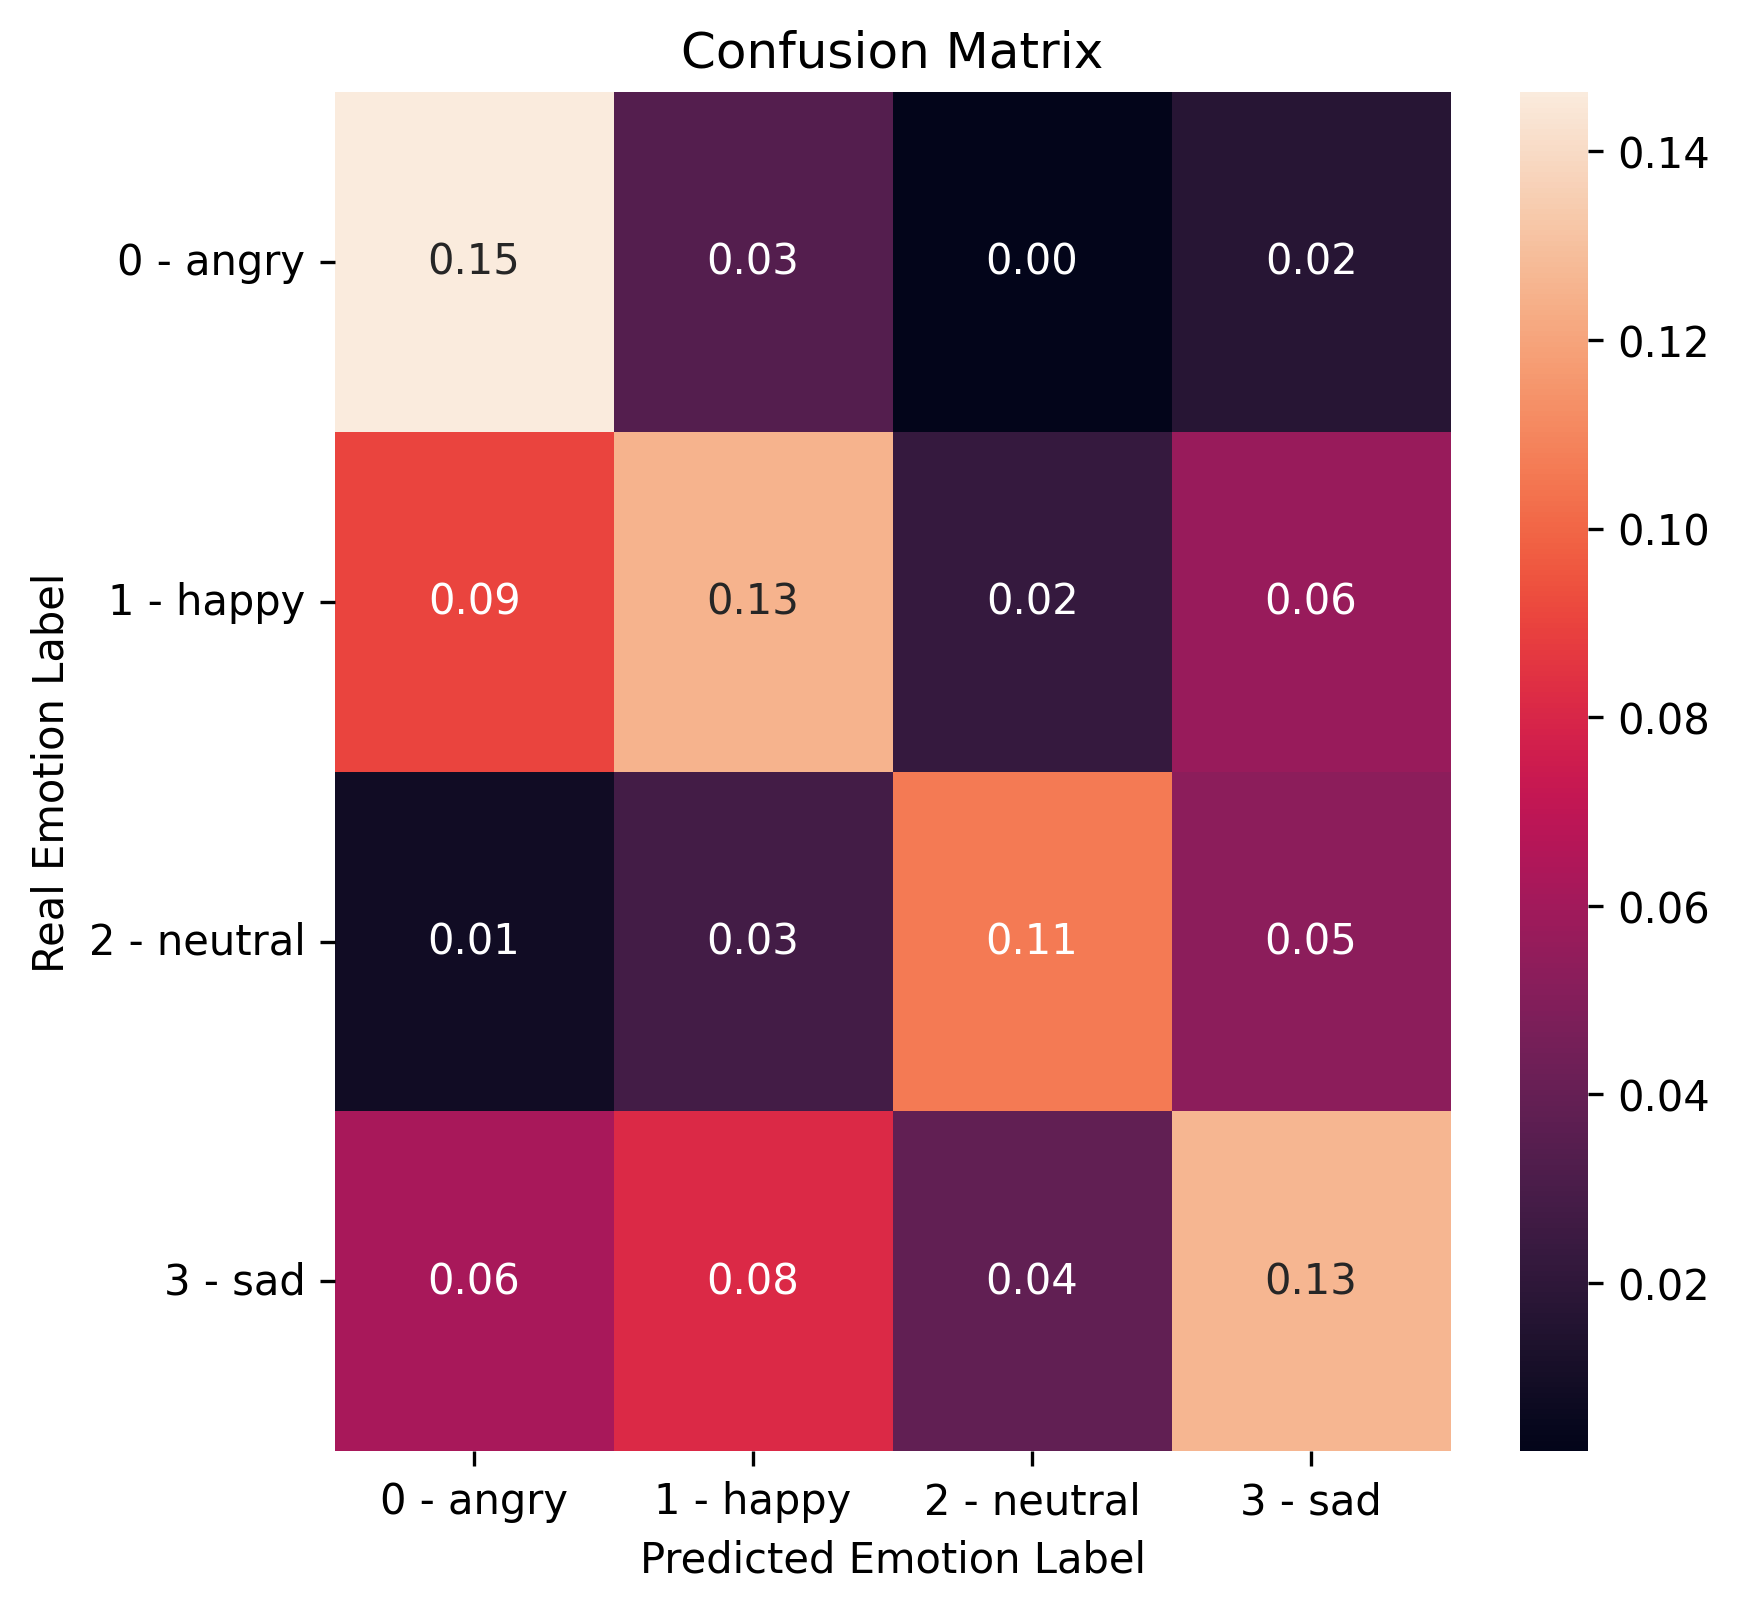

In [26]:
get_metrics(all_y_labels, all_y_pred, folds_size, training_times, prediction_times)

### LSTM

In [27]:
def build_model_1(input_shape=(33, 1), loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(33, 1)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax'),
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape=(33, 1), loss=loss, optimizer=optimizer)


get_new_model().summary(show_trainable=True)

Model: "sequential_6"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 lstm (LSTM)                 (None, 128)               66560     Y          
                                                                            
 dropout_18 (Dropout)        (None, 128)               0         Y          
                                                                            
 dense_6 (Dense)             (None, 32)                4128      Y          
                                                                            
 dropout_19 (Dropout)        (None, 32)                0         Y          
                                                                            
 dense_7 (Dense)             (None, 4)                 132       Y          
                                                                            
Total params: 70,820
Trainable params: 70,820
Non-trai

In [28]:
callback = EarlyStopping(monitor='val_loss', patience=40)
no_epochs = 50
batch_size = 16
verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, folds_size, training_times, prediction_times = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)

Epoch 1/50
277/277 [==============================] - 4s 10ms/step - loss: 1.2662 - accuracy: 0.3755 - val_loss: 1.2246 - val_accuracy: 0.4164
Epoch 2/50
277/277 [==============================] - 3s 12ms/step - loss: 1.2195 - accuracy: 0.3990 - val_loss: 1.1971 - val_accuracy: 0.4246
Epoch 3/50
277/277 [==============================] - 3s 12ms/step - loss: 1.1963 - accuracy: 0.4243 - val_loss: 1.1877 - val_accuracy: 0.4246
Epoch 4/50
277/277 [==============================] - 3s 12ms/step - loss: 1.1812 - accuracy: 0.4415 - val_loss: 1.1754 - val_accuracy: 0.4426
Epoch 5/50
277/277 [==============================] - 3s 12ms/step - loss: 1.1709 - accuracy: 0.4396 - val_loss: 1.1712 - val_accuracy: 0.4444
Epoch 6/50
277/277 [==============================] - 3s 12ms/step - loss: 1.1627 - accuracy: 0.4467 - val_loss: 1.1696 - val_accuracy: 0.4616
Epoch 7/50
277/277 [==============================] - 3s 12ms/step - loss: 1.1647 - accuracy: 0.4559 - val_loss: 1.1597 - val_accuracy: 0.4589

Accuracy for fold 0: 50.59%
Accuracy for fold 1: 51.08%
Accuracy for fold 2: 50.45%
Accuracy for fold 3: 50.9%
Accuracy for fold 4: 51.99%

Metric             Value
-----------------  -------------
Accuracy           51.0+-0.54
F1 score macro     51.42
Precision          51.35
Recall             51.87
Matthews corrcoef  0.339
Training Time      775.95+-17.61
Prediction Time    2.18+-0.03

              precision    recall  f1-score   support

           0       0.54      0.50      0.52      1103
           1       0.46      0.39      0.42      1636
           2       0.55      0.63      0.59      1084
           3       0.50      0.56      0.53      1708

    accuracy                           0.51      5531
   macro avg       0.51      0.52      0.51      5531
weighted avg       0.51      0.51      0.51      5531



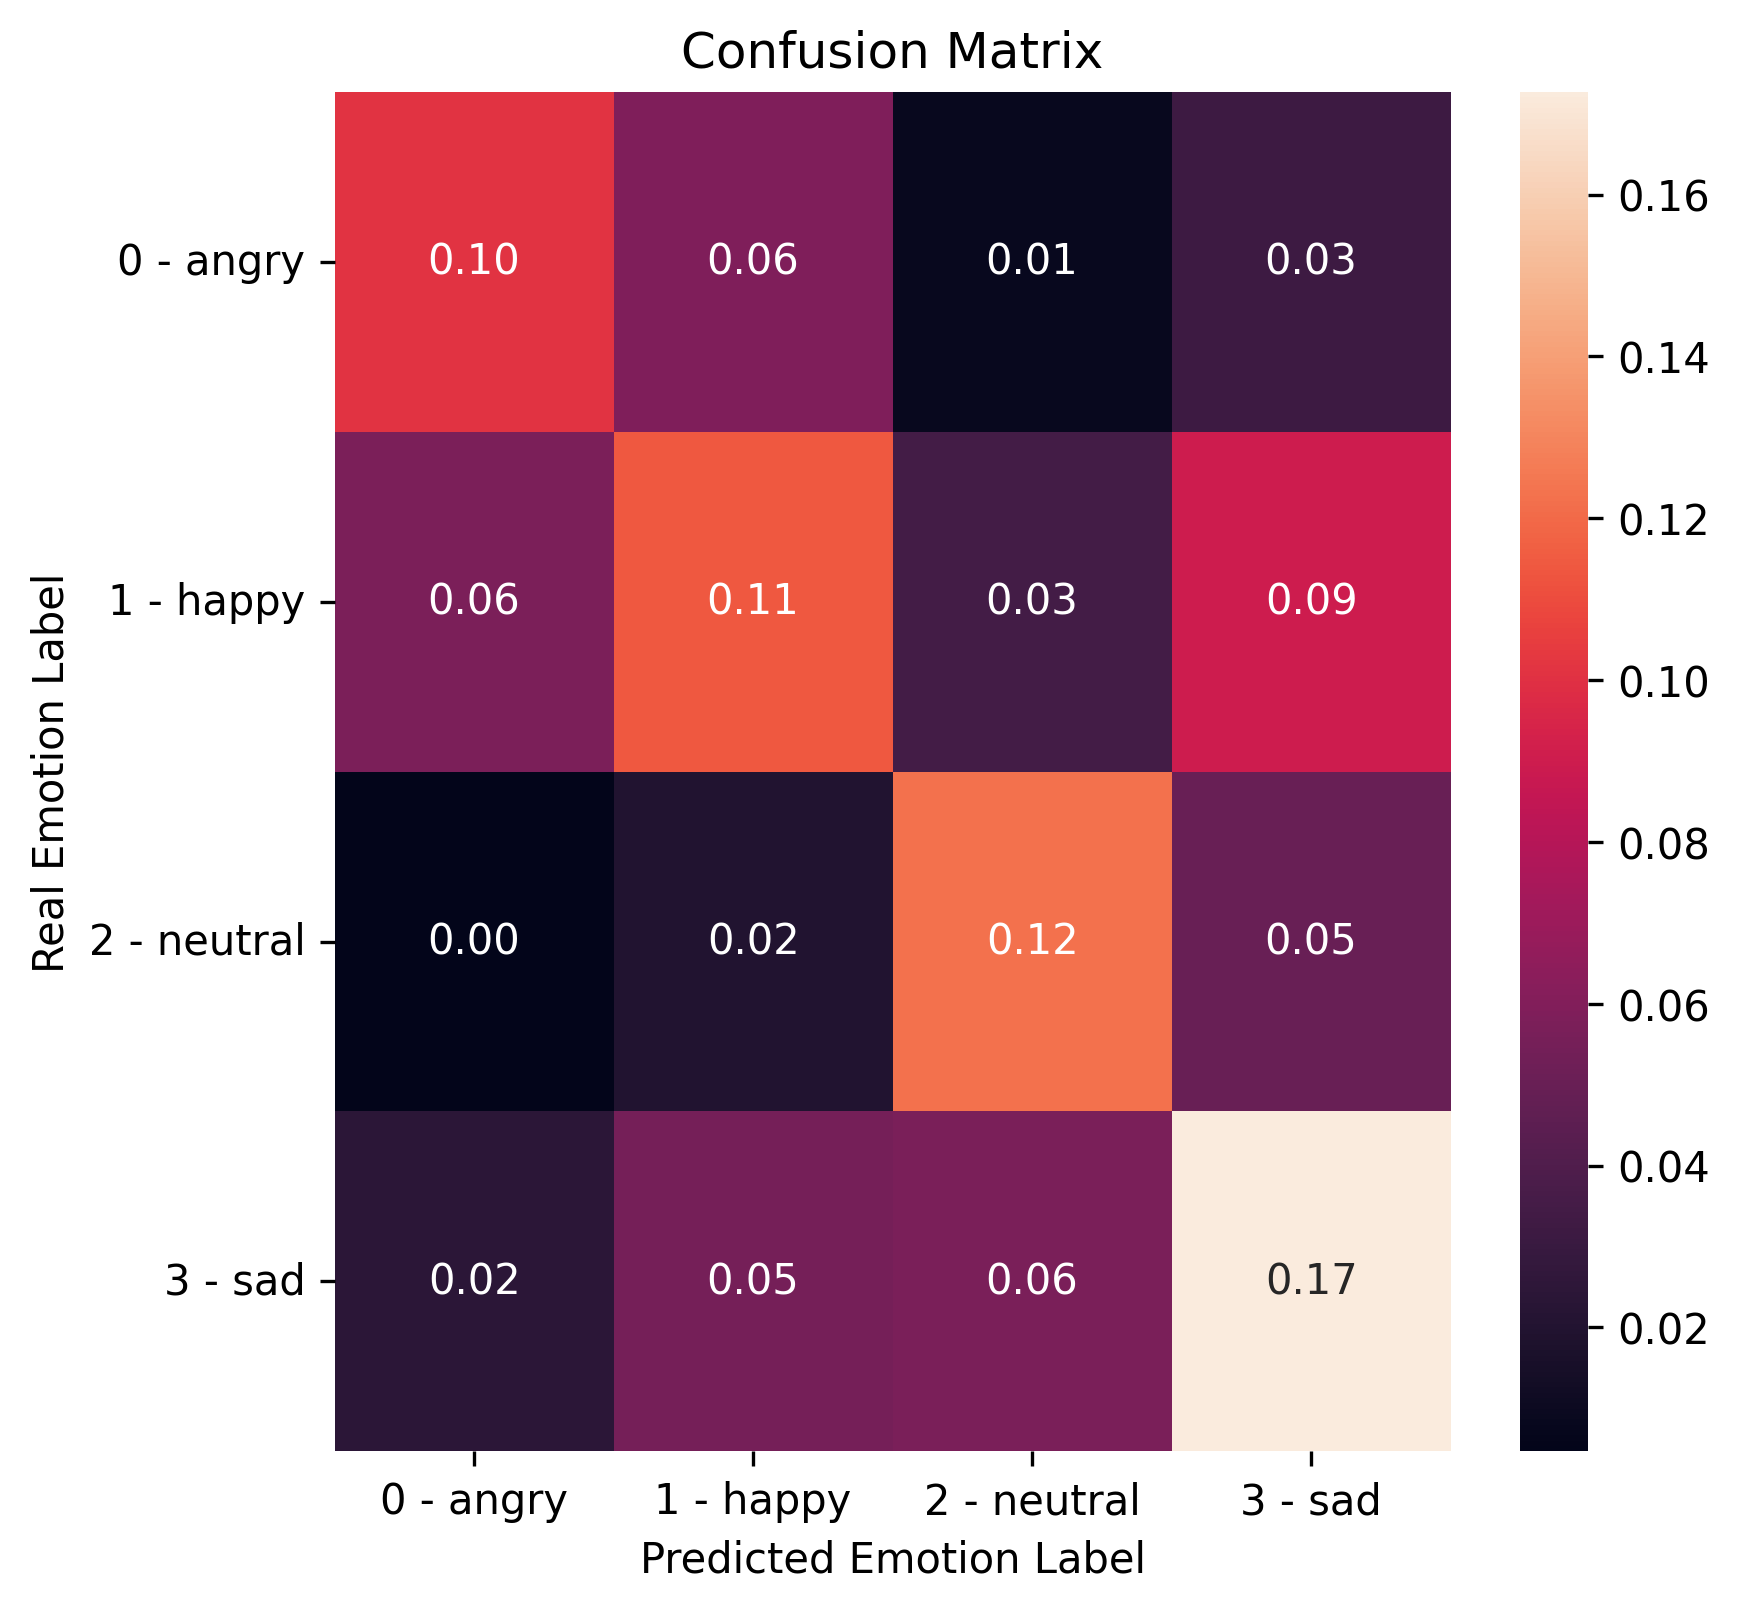

In [29]:
get_metrics(all_y_labels, all_y_pred, folds_size, training_times, prediction_times)

### AutoKeras

In [ ]:
def categorical_cross_validation(get_new_model, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
  
  X = df.iloc[:,9:]
  y = df.iloc[:,5:6]

  for train, _ in kfold.split(X, y):
    model = get_new_model(fold_no)
    
    X_train, y_train = X.iloc[train], y.iloc[train]

    model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    model.export_model()

    fold_no = fold_no + 1

no_epochs = 500
batch_size = 16

verbosity = 0
num_folds = 5

def get_new_model(fold_no):
    return ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"categorical_keras_model_fold_{fold_no}")
categorical_cross_validation(no_epochs, batch_size, verbosity, num_folds)

#### Testing the Models

Metric                  Value
-------------------  --------
Accuracy             0.427952
F1 score macro       0.420636
F1 score micro       0.427952
Precision            0.478266
Recall               0.408264
Hamming loss         0.572048
Matthews corrcoef    0.210925
Zero one loss        0.572048
Mean absolute error  0.973423


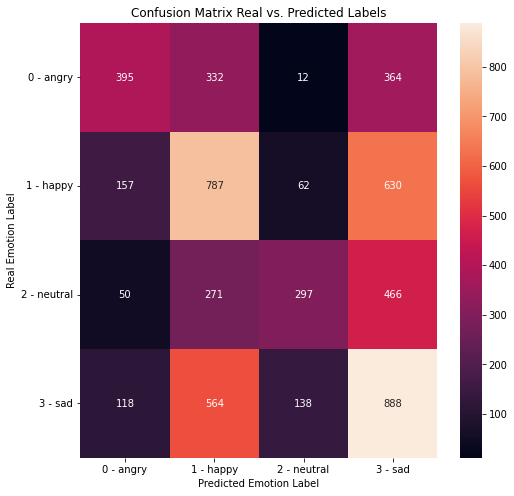

In [ ]:
def categorical_cross_validation(num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1

  X = df.iloc[:, 9:]
  y = df.iloc[:, 5:6]

  all_y_pred = []
  all_y_labels = []
  models_summary = []

  for _, test in kfold.split(X, y):
    # for linux
    # model = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/categorical_keras_model_fold_{fold_no}/structured_data_classifier/best_model"
    # for windows
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\categorical_keras_model_fold_{fold_no}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    models_summary.append(model.summary)

    X_test, y_test = X.iloc[test], y.iloc[test]

    y_pred = model.predict(X_test)
    y_pred = [list(x).index(max(x)) for x in y_pred]
    all_y_pred.extend(y_pred)
    all_y_labels.extend(y_test.values)

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)
  return models_summary

models_summary = categorical_cross_validation()

#### Models

In [ ]:
def print_model_summaries(models_summary):
  for i, summary in enumerate(models_summary):
    print(
        f'--------------------------Model of Fold {i+1} ----------------------------')
    summary()
print_model_summaries(models_summary)

--------------------------Model of Fold 1 ----------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 24)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 re_lu (ReLU)                (None, 16)                0         
                                                        

### AutoKeras - Mel-Spectogram as the Input Feature

In [19]:
spec_df = pd.read_csv(RAW_AUDIO_FILES)
print(f"Number of Audio Files: {spec_df.shape[0]}")
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
spec_df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 10039


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

emotion_id_label = {
  0: "angry",
  1: "happy",
  2: "neutral",
  3: "sad",
}

def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)

    # for windows
    return mel_spect, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)

    # for windows
    return mel_spect, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]

def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [5024]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [5024]), tf.reshape(labels, [4])


def preprocess_dataset(files, oneHotEncoding=False):
  # mac
    #   filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:\\Users\\Chico{str(file)[12:]}" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


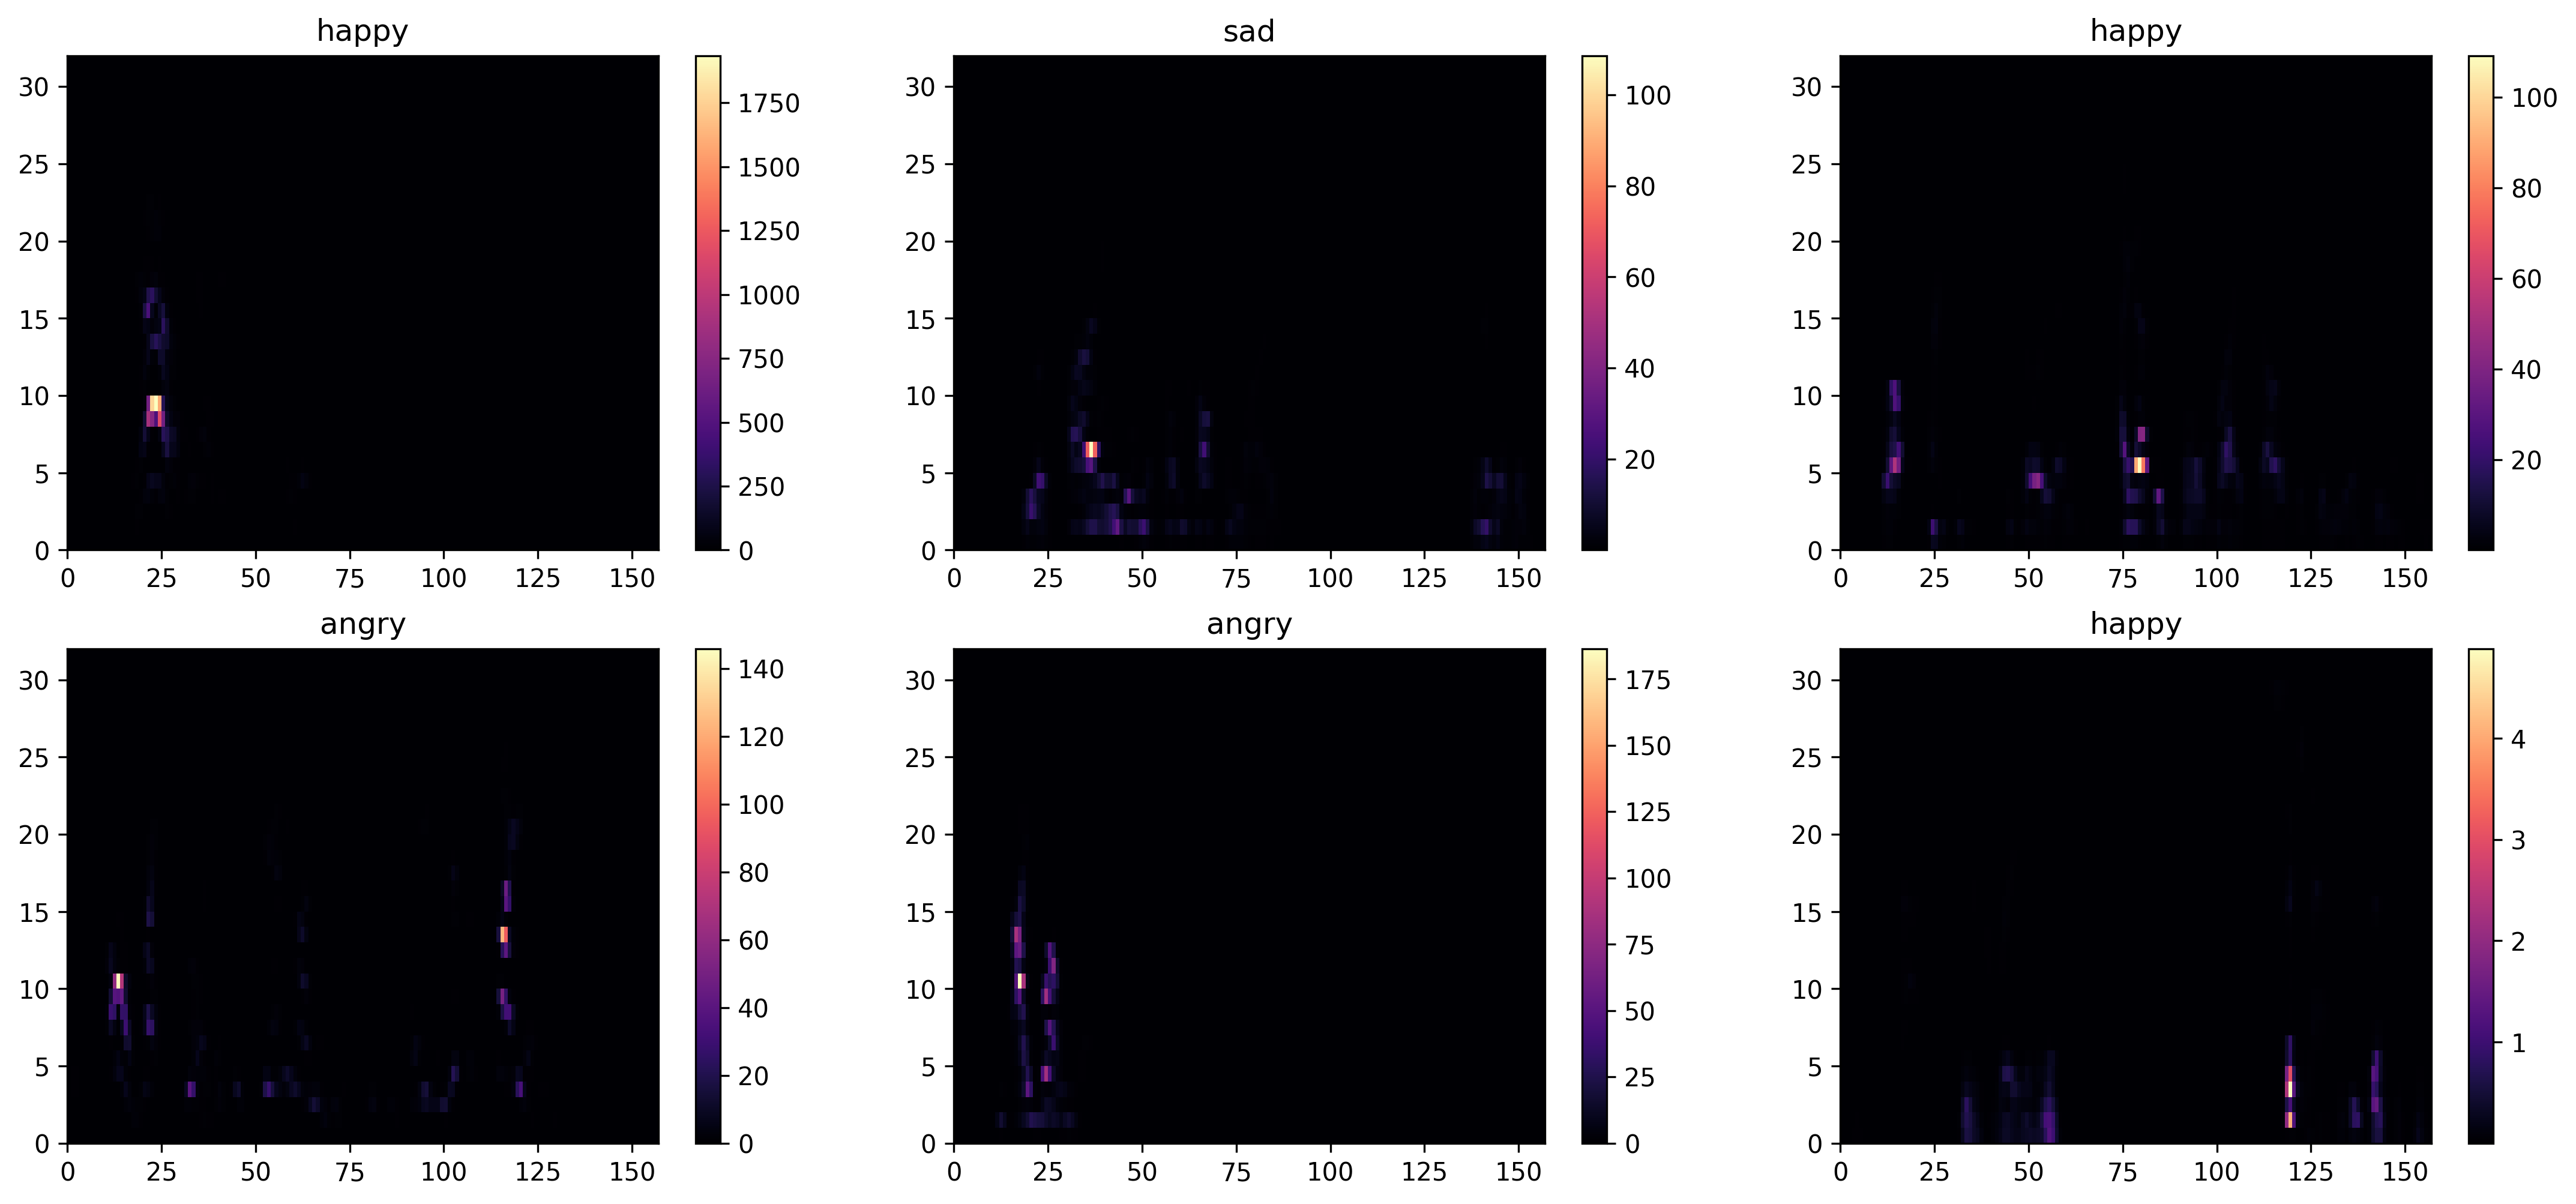

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, (audio, label) in enumerate(preprocess_dataset(spec_df).take(6)):
  r = i // 3
  c = i % 3
  ax = axes[r][c]
  spec = audio.numpy()
  spec = np.reshape(spec, (32, 157))
  im = ax.pcolormesh(spec, cmap="magma")
  fig.colorbar(im, ax=ax)
  label = label.numpy()[0]
  ax.set_title(emotion_id_label[label])

plt.show()

In [ ]:
def categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  fold_no = 1
  
  X = spec_df.iloc[:]
  y = spec_df.iloc[:,5:6]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=5, seed=1, directory=f"spec_categorical_keras_model_fold_{fold_no}")

    X_train = X.iloc[train]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    model.fit(train_ds,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[callback],
                workers=8)

    fold_no = fold_no + 1

no_epochs = 50
batch_size = 16

callback = EarlyStopping(monitor='loss', patience=10)

verbosity = 0
num_folds = 5

categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds)

#### Testing the Models

Metric                  Value
-------------------  --------
Accuracy             0.468128
F1 score macro       0.467898
F1 score micro       0.468128
Precision            0.472378
Recall               0.469612
Hamming loss         0.531872
Matthews corrcoef    0.281344
Zero one loss        0.531872
Mean absolute error  0.820072


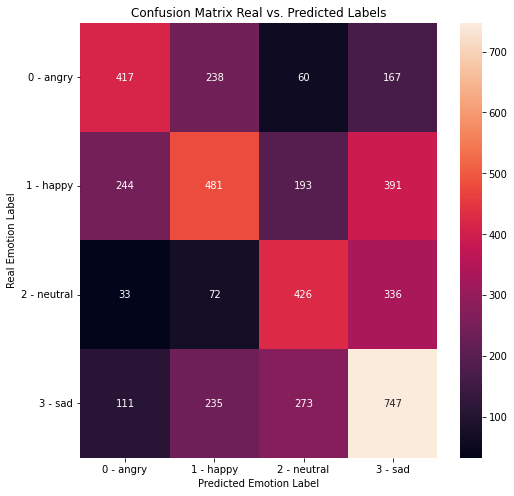

In [ ]:
def categorical_cross_validation(num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  all_y_pred = []
  all_y_labels = []
  models_summary = []
  fold_no = 1

  X = spec_df.iloc[:, ]
  y = spec_df.iloc[:, 5:6]

  for _, test in kfold.split(X, y):
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\spec_categorical_keras_model_fold_{fold_no}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    models_summary.append(model.summary)

    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)
  return models_summary

models_summary = categorical_cross_validation()

#### Models

In [ ]:
print_model_summaries(models_summary)

--------------------------Model of Fold 1 ----------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5024)]            0         
                                                                 
 multi_category_encoding (Mu  (None, 5024)             0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 5024)             10049     
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                160800    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                        

### AutoKeras - Mel-Spectogram as a Feature + Previous Selected Features

In [ ]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)
    
    audio_idx = audio_file.split("\\")[-1][:-4]
    # for linux
    # audio_idx = audio_file.split("/")[-1][:-4]
    audio_features = df.loc[audio_idx][9:]
    audio_features = np.reshape(audio_features, -1)

    # for windows
    return np.concatenate((audio_features, mel_spect), axis=0), spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    y, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast')

    input_len = sr * 5
    y = y[:input_len]
    # Zero-padding for an audio waveform with less than 5 seconds.
    if (input_len > tf.shape(y)[0]):
        zero_padding = tf.zeros(
            [input_len] - tf.shape(y),
            dtype=tf.float32)
        y = tf.cast(y, dtype=tf.float32)
        y = tf.concat([y, zero_padding], 0)
        y = y.numpy()

    mel_spect = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=config.n_mels)
    mel_spect = np.reshape(mel_spect, -1)
    # for windows
    audio_idx = audio_file.split("\\")[-1][:-4]
    # for linux
    # audio_idx = audio_file.split("/")[-1][:-4]
    audio_features = df.loc[audio_idx][9:]
    audio_features = np.reshape(audio_features, -1)

    # for windows
    return np.concatenate((audio_features, mel_spect), axis=0), OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return np.concatenate((audio_features, mel_spect), axis=0), OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [5048]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [5048]), tf.reshape(labels, [4])


In [ ]:
def categorical_cross_validation(callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 5:6]

  fold_no = 1
  for train, _ in kfold.split(X, y):
    model = ak.StructuredDataClassifier(
        overwrite=True, max_trials=5, seed=1, directory=f"feat_and_spec_categorical_keras_model_fold_{fold_no}")

    X_train = X.iloc[train]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    fold_no = fold_no + 1

no_epochs = 50
batch_size = 16

callback = EarlyStopping(monitor='loss', patience=10)

verbosity = 0
num_folds = 5

categorical_cross_validation(
    callback, no_epochs, batch_size, verbosity, num_folds)


#### Testing the Models

Metric                  Value
-------------------  --------
Accuracy             0.504972
F1 score macro       0.508452
F1 score micro       0.504972
Precision            0.50788
Recall               0.519167
Hamming loss         0.495028
Matthews corrcoef    0.336131
Zero one loss        0.495028
Mean absolute error  0.774905


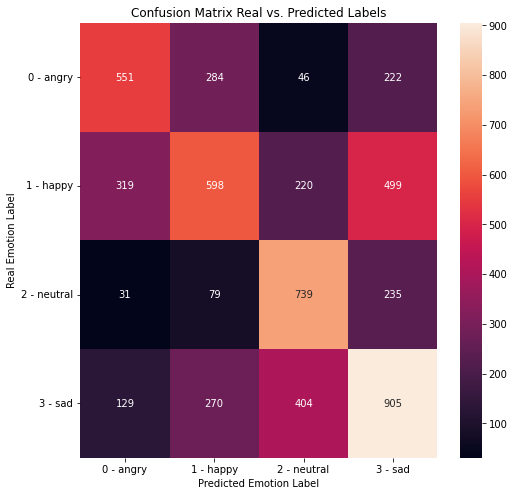

In [ ]:
def categorical_cross_validation(num_folds=5, draw_corr_matrix=True):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  all_y_pred = []
  all_y_labels = []
  models_summary = []
  fold_no = 1

  X = spec_df.iloc[:, ]
  y = spec_df.iloc[:, 5:6]

  for _, test in kfold.split(X, y):
    model = f"{os.path.abspath('./../../../')}\\Audio_Sentiment_Analysis\\iemocap\\model\\feat_and_spec_categorical_keras_model_fold_{fold_no}\\structured_data_classifier\\best_model"
    model = tf.keras.models.load_model(model, custom_objects=ak.CUSTOM_OBJECTS)
    models_summary.append(model.summary)

    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, draw_corr_matrix)

  return models_summary

models_summary = categorical_cross_validation()

#### Models

In [ ]:
print_model_summaries(models_summary)

--------------------------Model of Fold 1 ----------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5048)]            0         
                                                                 
 multi_category_encoding (Mu  (None, 5048)             0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 5048)             10097     
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                161568    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                        

### CNN - Takes too long to run on my PC

In [3]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 5:6]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    X_train = X.iloc[train]

    train_ds = preprocess_dataset(X_train)
    train_ds = train_ds.batch(16)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    X_test = X.iloc[test]

    test_ds = preprocess_dataset(X_test, True)
    test_ds = test_ds.batch(16)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  get_metrics(all_y_labels, all_y_pred, True)


callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 50
batch_size = 64

verbosity = 1
num_folds = 5


def get_new_model():
  learning_rate = 1e-5
  loss = SparseCategoricalCrossentropy()
  optimizer = Adam(learning_rate=learning_rate)
  return build_model_0(input_shape=(5048, 1), loss=loss, optimizer=optimizer)


categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


NameError: name 'spec_df' is not defined

## Spectogram as a Feature

In [3]:
class ADJUSTLR(Callback):
    def __init__ (self, model, verbose):
        self.model = model
        self.freq = 5
        self.factor = .9
        self.verbose = verbose
        self.adj_epoch = 5
    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 == self.adj_epoch: # adjust the learning rate
            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
            new_lr=lr * self.factor
            self.adj_epoch +=self.freq
            if self.verbose == 1:
                print('\non epoch ',epoch + 1, ' lr was adjusted from ', lr, ' to ', new_lr)
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer

def categorical_cross_validation(get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  training_times = []
  prediction_times = []

  X = data_df.iloc[:]
  y = data_df.iloc[:, 1]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds.iloc[:, 0].values)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds.iloc[:, 0].values)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')
    callback = ADJUSTLR(model, verbosity)

    start_time = time.time()
    model.fit(train_ds,
              validation_data=test_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1)
    training_times.append(time.time() - start_time)

    start_time = time.time()
    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      y_pred = [list(x).index(max(x)) for x in y_pred]
      all_y_pred.extend(y_pred)
      y_label = [x[0] for x in label.numpy()]
      all_y_labels.extend(y_label)
    prediction_times.append(time.time() - start_time)

    print(f"Accuracy for fold {fold_no}: {round(metrics.accuracy_score(y_label, y_pred) * 100, 2)}%")

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred, training_times, prediction_times

In [26]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))

    with open(audio_file, 'rb') as f:
        y = pickle.load(f)
    
    y = np.reshape(y, (1025, 188, 1))

    return y, int(audio_file.split('-')[1][0])


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])

    return tf.reshape(features, [1025, 188, 1]), tf.reshape(labels, [1])


def preprocess_dataset(files):
  filenames_ds = tf.data.Dataset.list_files(files)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

In [6]:
data_df = pd.DataFrame([(file, file[-5]) for file in glob(f"{AUDIO_SPECTROGRAMS_DIR}*.pickle")])
print(len(data_df))

5531


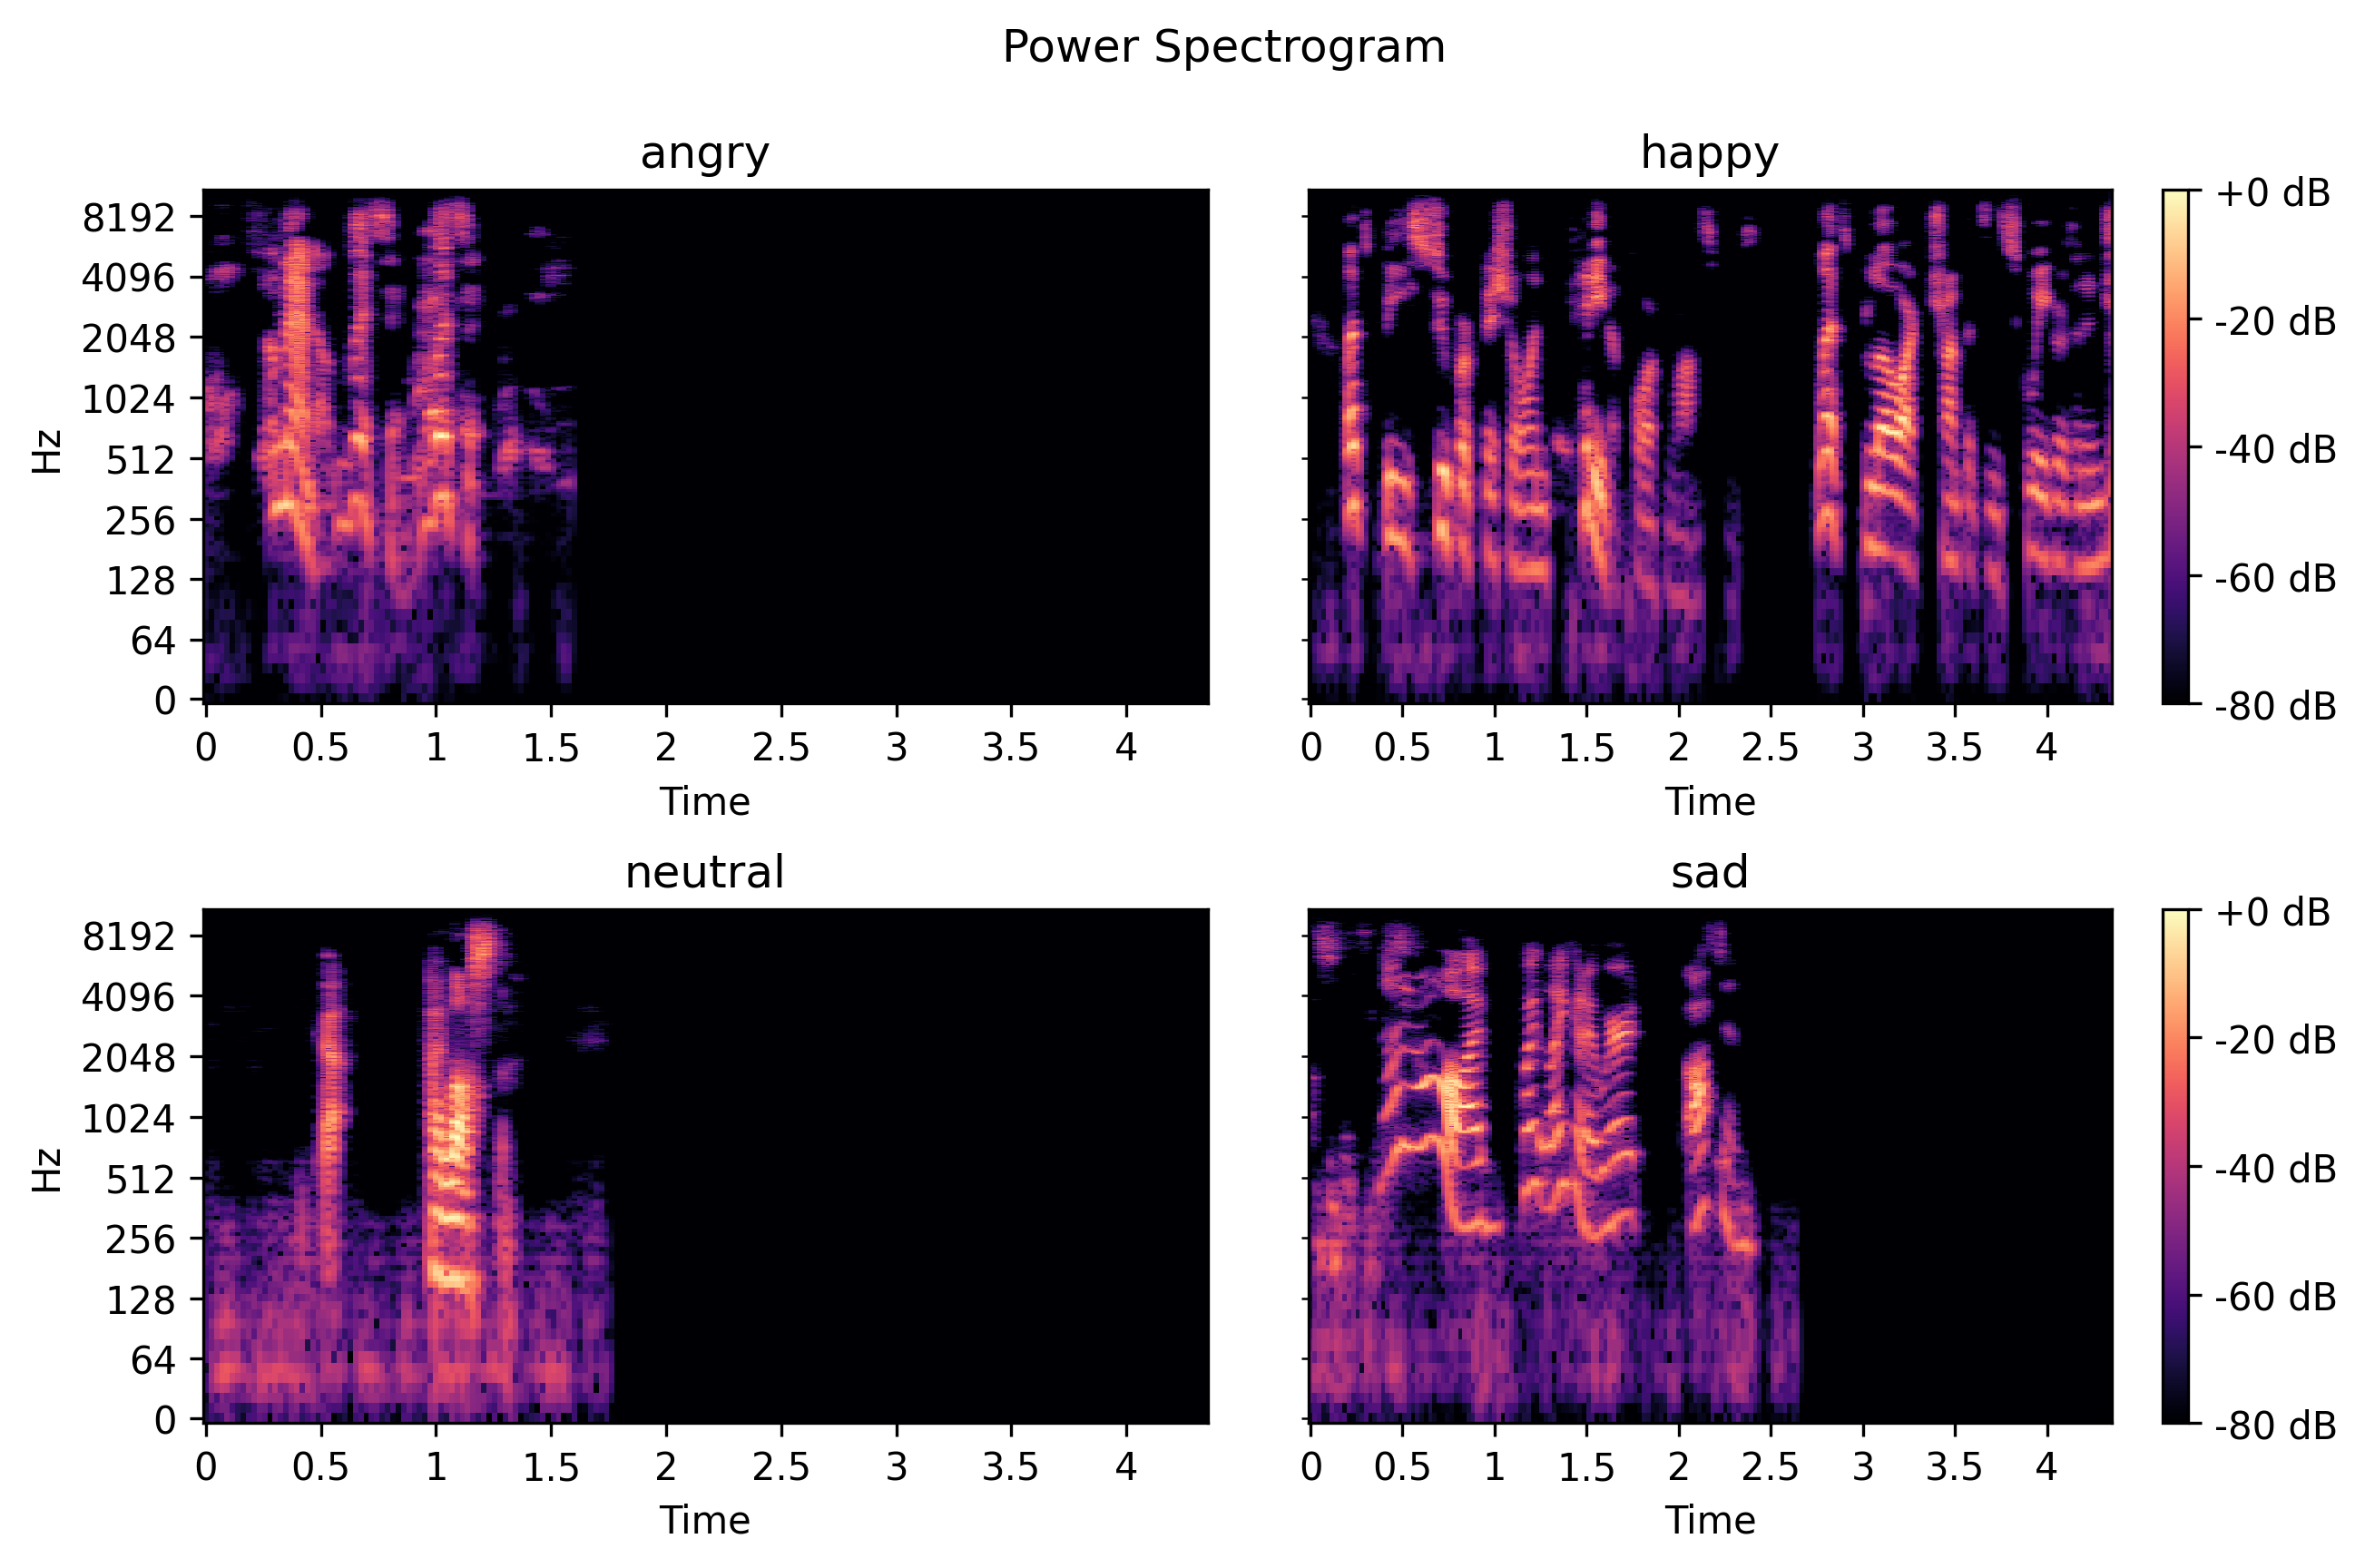

In [29]:
emotion_id_label = {
    0: "angry",
    1: "happy",
    2: "neutral",
    3: "sad",
}

fig, axes = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=False)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.4)

labels = set()
i = 0
for audio, label in preprocess_dataset(data_df.iloc[:, 0].values).take(10):
  label = label.numpy()[0]
  if i == 4:
    break
  if label in labels:
    continue
  r = i // 2
  c = i % 2
  ax = axes[r][c]
  spec = audio.numpy()
  spec = np.reshape(spec, (1025, 188))
  img = librosa.display.specshow(librosa.amplitude_to_db(
      spec, ref=np.max), y_axis='log', x_axis='time', ax=ax)
  if c == 1:
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set_ylabel("")
    ax.set_yticks([])
  ax.set_title(emotion_id_label[label])
  labels.add(label)
  i += 1

fig.suptitle('Power Spectrogram')
plt.show()

In [30]:
def build_model_1(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, 7, strides=2, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 5, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 3, strides=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

def get_new_model():
    input_shape = (1025, 188, 1)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)


get_new_model().summary(show_trainable=True)


Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 513, 94, 16)       800       Y          
                                                                            
 activation (Activation)     (None, 513, 94, 16)       0         Y          
                                                                            
 batch_normalization (BatchN  (None, 513, 94, 16)      64        Y          
 ormalization)                                                              
                                                                            
 conv2d_1 (Conv2D)           (None, 257, 47, 32)       12832     Y          
                                                                            
 activation_1 (Activation)   (None, 257, 47, 32)       0         Y          
                                                        

In [32]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 16

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
277/277 [==============================] - 114s 409ms/step - loss: 2.1108 - accuracy: 0.3958 - val_loss: 1.2328 - val_accuracy: 0.4354
Epoch 2/50
277/277 [==============================] - 108s 391ms/step - loss: 1.2920 - accuracy: 0.4778 - val_loss: 1.3065 - val_accuracy: 0.3198
Epoch 3/50
277/277 [==============================] - 109s 394ms/step - loss: 1.0522 - accuracy: 0.5463 - val_loss: 1.4921 - val_accuracy: 0.3297
Epoch 4/50
277/277 [==============================] - 95s 343ms/step - loss: 0.9503 - accuracy: 0.5974 - val_loss: 2.1827 - val_accuracy: 0.3270
Epoch 5/50
277/277 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6313
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
277/277 [==============================] - 89s 321ms/step - loss: 0.8781 - accuracy: 0.6313 - val_loss: 2.6917 - val_accuracy: 0.3008
Epoch 6/50
277/277 [==============================] - 86s 309ms/step - loss: 0.

KeyboardInterrupt: 

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times)

In [74]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (12, 16), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(24, (8, 12), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, (5, 7), padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

def get_new_model_2():
    input_shape = (1025, 188, 1)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)

get_new_model_2().summary(show_trainable=True)

Model: "sequential_67"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_327 (Conv2D)         (None, 1014, 173, 16)     3088      Y          
                                                                            
 max_pooling2d_102 (MaxPooli  (None, 507, 86, 16)      0         Y          
 ng2D)                                                                      
                                                                            
 conv2d_328 (Conv2D)         (None, 500, 75, 24)       36888     Y          
                                                                            
 max_pooling2d_103 (MaxPooli  (None, 250, 37, 24)      0         Y          
 ng2D)                                                                      
                                                                            
 conv2d_329 (Conv2D)         (None, 250, 37, 32)     

In [76]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model_2, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50


KeyboardInterrupt: 

## MFCC as Feature

In [186]:
AUTOTUNE = tf.data.AUTOTUNE
spec_df = pd.read_csv(RAW_AUDIO_FILES)
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin(
    {'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
print(f"Number of Audio Files: {spec_df.shape[0]}")
print(spec_df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))

Number of Audio Files: 5531
                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084


In [79]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))

    with open(f'{AUDIO_MFCCS_DIR}{audio_file}-mfcc.pickle', 'rb') as f:
        y = pickle.load(f)

    return y, int(audio_file.split('-')[1][0])

def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])

    return tf.reshape(features, [20, 188]), tf.reshape(labels, [1])

def preprocess_dataset(files):
  filenames_ds = tf.data.Dataset.from_tensor_slices(files.index.values)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

In [195]:
def build_model_1(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv1D(32, 8, strides=2, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 6, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 6, strides=3, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(256, 4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (20, 188)
    learning_rate = 1e-5
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

Model: "sequential_132"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d_745 (Conv1D)         (None, 10, 32)            48160     Y          
                                                                            
 activation_877 (Activation)  (None, 10, 32)           0         Y          
                                                                            
 batch_normalization_714 (Ba  (None, 10, 32)           128       Y          
 tchNormalization)                                                          
                                                                            
 conv1d_746 (Conv1D)         (None, 5, 64)             12352     Y          
                                                                            
 activation_878 (Activation)  (None, 5, 64)            0         Y          
                                                    

In [196]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/100
35/35 [==============================] - 5s 123ms/step - loss: 2.2427 - accuracy: 0.2703 - val_loss: 1.3864 - val_accuracy: 0.1915
Epoch 2/100
35/35 [==============================] - 1s 23ms/step - loss: 2.1117 - accuracy: 0.2984 - val_loss: 1.3866 - val_accuracy: 0.1924
Epoch 3/100
35/35 [==============================] - 1s 23ms/step - loss: 1.9787 - accuracy: 0.3287 - val_loss: 1.3829 - val_accuracy: 0.2213
Epoch 4/100
35/35 [==============================] - 1s 23ms/step - loss: 1.9420 - accuracy: 0.3413 - val_loss: 1.3753 - val_accuracy: 0.3568
Epoch 5/100
35/35 [==============================] - 1s 22ms/step - loss: 1.8339 - accuracy: 0.3590 - val_loss: 1.3637 - val_accuracy: 0.3622
Epoch 6/100
35/35 [==============================] - 1s 22ms/step - loss: 1.7950 - accuracy: 0.3716 - val_loss: 1.3504 - val_accuracy: 0.3794
Epoch 7/100
35/35 [==============================] - 1s 22ms/step - loss: 1.7563 - accuracy: 0.3757 - val_loss: 1.3390 - va

KeyboardInterrupt: 

In [162]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (10, 12), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Conv2D(24, (4, 6), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

def get_new_model_2():
    input_shape = (20, 188, 1)
    learning_rate = 1e-4
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)

get_new_model_2().summary(show_trainable=True)

Model: "sequential_157"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_523 (Conv2D)         (None, 11, 177, 16)       1936      Y          
                                                                            
 max_pooling2d_234 (MaxPooli  (None, 5, 88, 16)        0         Y          
 ng2D)                                                                      
                                                                            
 batch_normalization_342 (Ba  (None, 5, 88, 16)        64        Y          
 tchNormalization)                                                          
                                                                            
 dropout_204 (Dropout)       (None, 5, 88, 16)         0         Y          
                                                                            
 conv2d_524 (Conv2D)         (None, 2, 83, 24)      

## Mel-Spectrogram as a Feature

In [3]:
data_df = pd.DataFrame([(file, file[-5]) for file in glob(f"{AUDIO_MEL_SPECTROGRAMS_DIR}*.pickle")])
print(len(data_df))

5531


In [21]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))

    with open(audio_file, 'rb') as f:
        y = pickle.load(f)
    
    y = np.reshape(y, (128, 128, 1))

    return y, int(audio_file.split('-')[1][0])


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])

    return tf.reshape(features, [128, 128, 1]), tf.reshape(labels, [1])


def preprocess_dataset(files):
  filenames_ds = tf.data.Dataset.list_files(files)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

In [5]:
def build_model_1(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, 7, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 3, strides=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

def get_new_model():
    input_shape = (128, 128, 1)
    learning_rate = 1e-4
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_1(input_shape, loss, optimizer)

get_new_model().summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 64, 64, 16)        800       Y          
                                                                            
 batch_normalization (BatchN  (None, 64, 64, 16)       64        Y          
 ormalization)                                                              
                                                                            
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        12832     Y          
                                                                            
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       Y          
 hNormalization)                                                            
                                                                            
 conv2d_2 (Conv2D)           (None, 11, 11, 32)        9

In [40]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (12, 16), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(24, (8, 12), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, (5, 7), padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

def get_new_model_2():
    input_shape = (128, 128, 1)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)


get_new_model_2().summary(show_trainable=True)

Model: "sequential_37"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_216 (Conv2D)         (None, 117, 113, 16)      3088      Y          
                                                                            
 max_pooling2d_21 (MaxPoolin  (None, 58, 56, 16)       0         Y          
 g2D)                                                                       
                                                                            
 conv2d_217 (Conv2D)         (None, 51, 45, 24)        36888     Y          
                                                                            
 max_pooling2d_22 (MaxPoolin  (None, 25, 22, 24)       0         Y          
 g2D)                                                                       
                                                                            
 conv2d_218 (Conv2D)         (None, 25, 22, 32)      

In [ ]:
def ReshapeLayer(x):
    shape = x.shape
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    return reshape

def build_model_3(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (12, 16), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(24, (8, 12), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, (5, 7), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Lambda(ReshapeLayer))
    model.add(Bidirectional(LSTM(32)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

def get_new_model_3():
    input_shape = (128, 128, 1)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_3(input_shape, loss, optimizer)


get_new_model_3().summary(show_trainable=True)

In [ ]:
def build_model_4(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (12, 16), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(24, (8, 12), activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(32, (5, 7), padding='same', activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model
    
def get_new_model_4():
    input_shape = (128, 128, 1)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_4(input_shape, loss, optimizer)

get_new_model_4().summary(show_trainable=True)

In [20]:
def get_new_model_5():
    model = tf.keras.applications.Xception(
        weights=None,
        input_shape=(128, 128, 1),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(128, 128, 1))
    x = model(inputs, training=False)
    # x = Dense(64)(x)
    x = Dropout(0.75)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

get_new_model_5().summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20860904  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 20,869,100
Trainable params: 8,196
Non-trainable params: 20,860,904
_________________________________________________________________


In [41]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model_2, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
35/35 [==============================] - 36s 1s/step - loss: 1.8377 - accuracy: 0.3429 - val_loss: 1.4947 - val_accuracy: 0.4065
Epoch 2/50
35/35 [==============================] - 35s 1s/step - loss: 1.4428 - accuracy: 0.3614 - val_loss: 1.3026 - val_accuracy: 0.4137
Epoch 3/50
35/35 [==============================] - 34s 986ms/step - loss: 1.3476 - accuracy: 0.3721 - val_loss: 1.3216 - val_accuracy: 0.4318
Epoch 4/50
35/35 [==============================] - 37s 1s/step - loss: 1.3522 - accuracy: 0.3802 - val_loss: 1.2793 - val_accuracy: 0.4038
Epoch 5/50
35/35 [==============================] - 34s 967ms/step - loss: 1.2952 - accuracy: 0.3895 - val_loss: 1.2529 - val_accuracy: 0.4119
Epoch 6/50
35/35 [==============================] - 35s 1s/step - loss: 1.2669 - accuracy: 0.3843 - val_loss: 1.2353 - val_accuracy: 0.3939
Epoch 7/50
35/35 [==============================] - 37s 1s/step - loss: 1.2365 - accuracy: 0.4168 - val_loss: 1.2353 - val_accurac

Accuracy for fold 0: 50.63%
Accuracy for fold 1: 51.72%
Accuracy for fold 2: 50.0%
Accuracy for fold 3: 51.54%
Accuracy for fold 4: 51.45%

Metric             Value
-----------------  -------------
Accuracy           51.06+-0.65
F1 score macro     51.67
Precision          51.73
Recall             51.75
Matthews corrcoef  0.337
Training Time      8525.39+-4.14
Prediction Time    6.98+-0.06

              precision    recall  f1-score   support

           0       0.54      0.49      0.51      1103
           1       0.45      0.43      0.44      1636
           2       0.58      0.62      0.60      1084
           3       0.50      0.54      0.52      1708

    accuracy                           0.51      5531
   macro avg       0.52      0.52      0.52      5531
weighted avg       0.51      0.51      0.51      5531



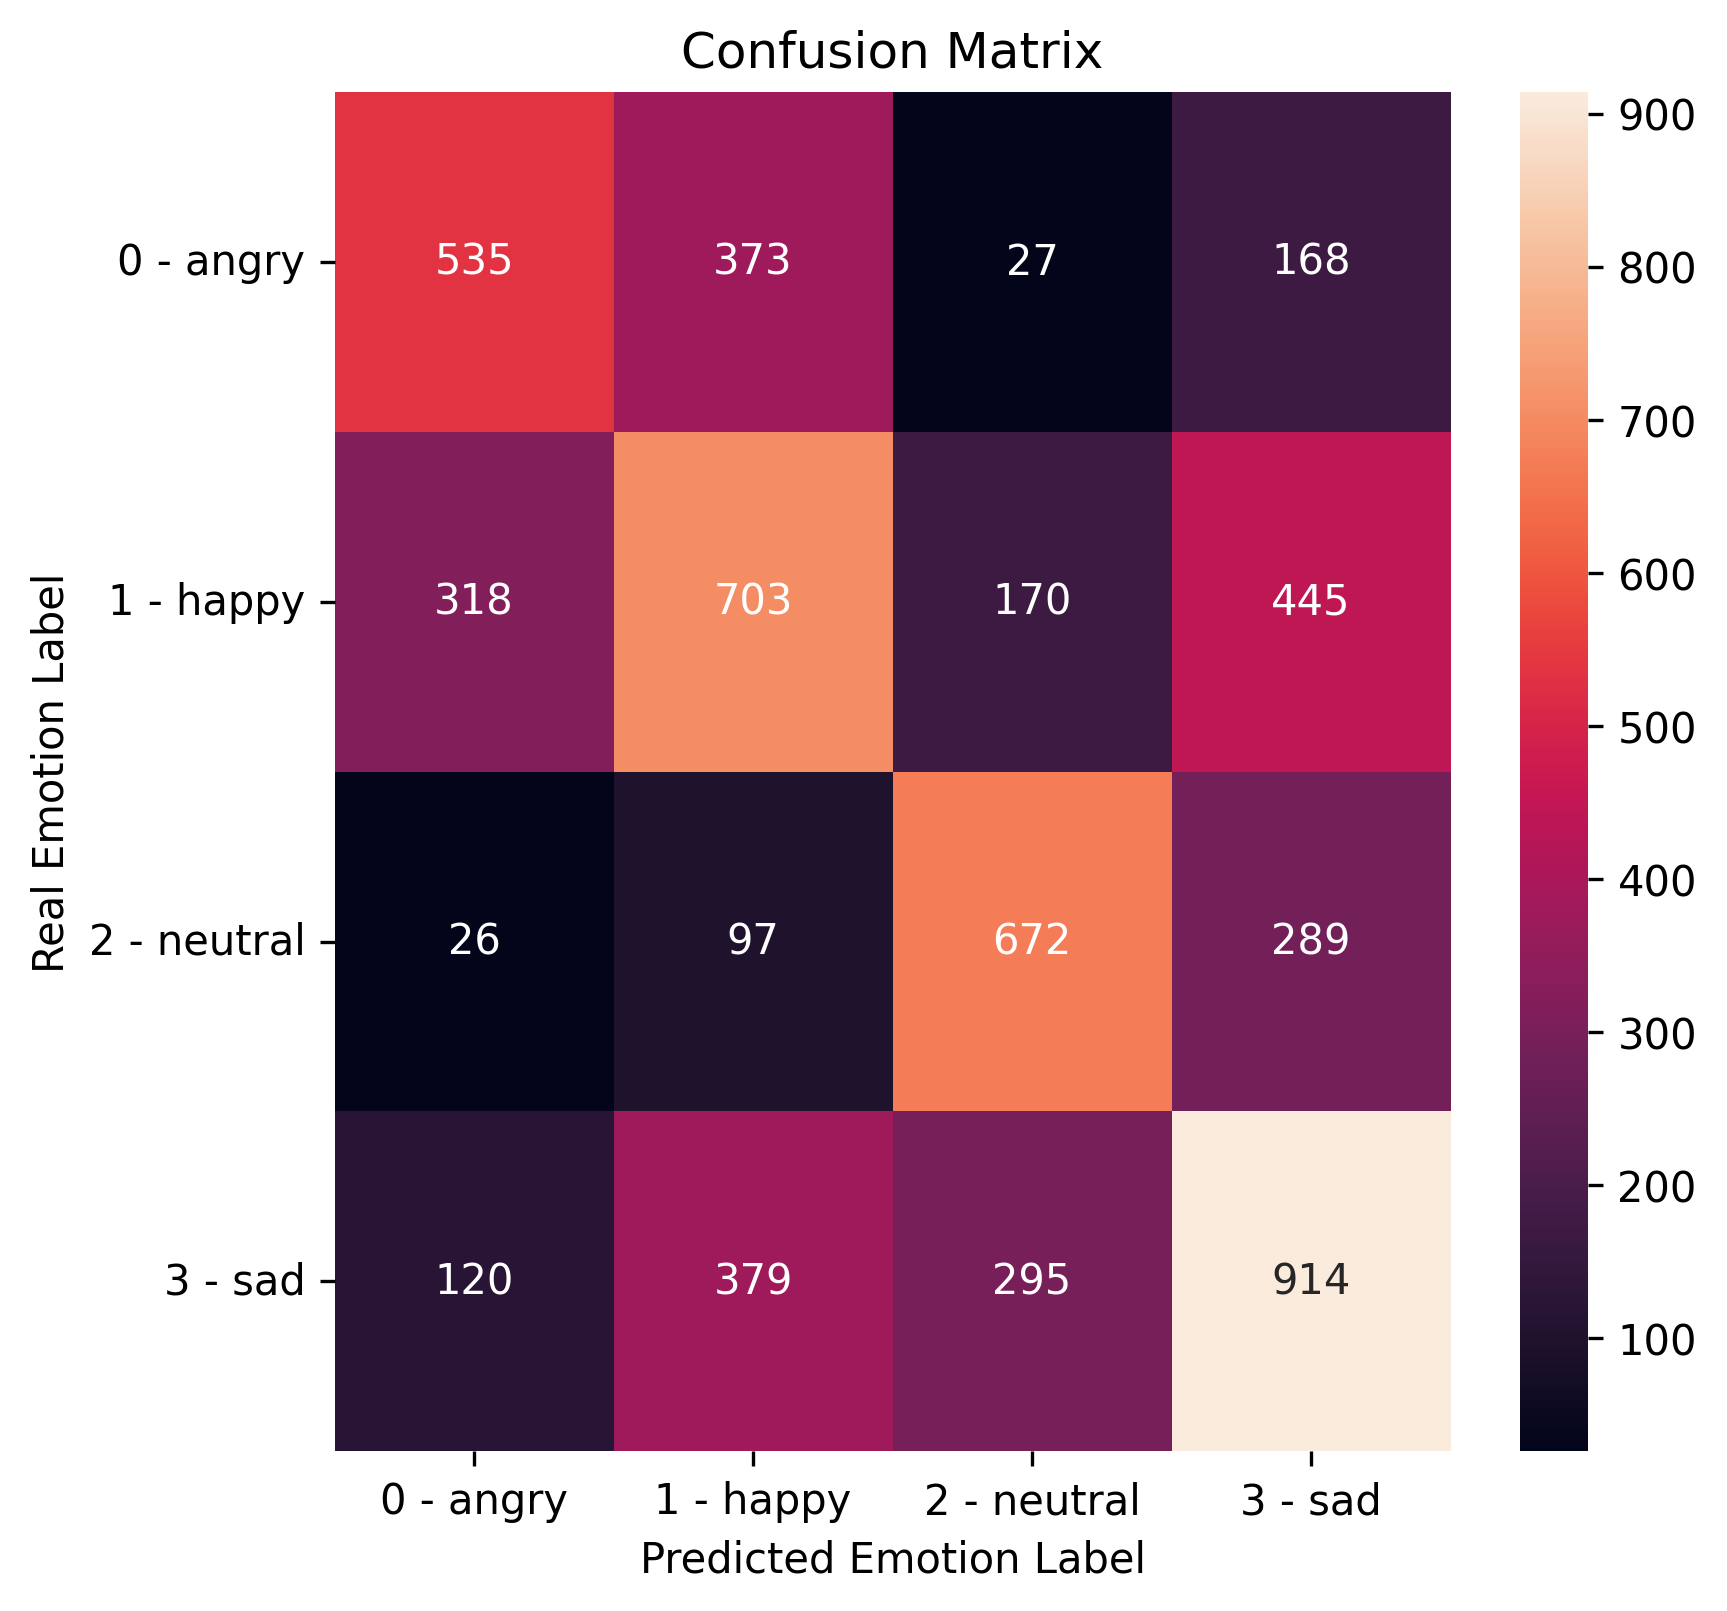

In [44]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times, True)

In [167]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model_3, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
35/35 [==============================] - 36s 968ms/step - loss: 1.2882 - accuracy: 0.3666 - val_loss: 1.1902 - val_accuracy: 0.4598
Epoch 2/50
35/35 [==============================] - 33s 943ms/step - loss: 1.1995 - accuracy: 0.4340 - val_loss: 1.1500 - val_accuracy: 0.4670
Epoch 3/50
35/35 [==============================] - 33s 949ms/step - loss: 1.1698 - accuracy: 0.4516 - val_loss: 1.1335 - val_accuracy: 0.4670
Epoch 4/50
35/35 [==============================] - 33s 954ms/step - loss: 1.1506 - accuracy: 0.4528 - val_loss: 1.1268 - val_accuracy: 0.4806
Epoch 5/50
35/35 [==============================] - 33s 943ms/step - loss: 1.1426 - accuracy: 0.4632 - val_loss: 1.1314 - val_accuracy: 0.4652
Epoch 6/50
35/35 [==============================] - 32s 927ms/step - loss: 1.1527 - accuracy: 0.4641 - val_loss: 1.1314 - val_accuracy: 0.4788
Epoch 7/50
35/35 [==============================] - 32s 926ms/step - loss: 1.1320 - accuracy: 0.4783 - val_loss: 1.124

KeyboardInterrupt: 

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times, True)

In [171]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model_3, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
35/35 [==============================] - 37s 992ms/step - loss: 1.2943 - accuracy: 0.3770 - val_loss: 1.1875 - val_accuracy: 0.4408
Epoch 2/50
35/35 [==============================] - 33s 929ms/step - loss: 1.2148 - accuracy: 0.4193 - val_loss: 1.1754 - val_accuracy: 0.4571
Epoch 3/50
35/35 [==============================] - 34s 965ms/step - loss: 1.1971 - accuracy: 0.4363 - val_loss: 1.1502 - val_accuracy: 0.4734
Epoch 4/50
35/35 [==============================] - 33s 933ms/step - loss: 1.1755 - accuracy: 0.4458 - val_loss: 1.1447 - val_accuracy: 0.4697
Epoch 5/50
35/35 [==============================] - 33s 938ms/step - loss: 1.1675 - accuracy: 0.4541 - val_loss: 1.1432 - val_accuracy: 0.4724
Epoch 6/50
35/35 [==============================] - 33s 945ms/step - loss: 1.1605 - accuracy: 0.4537 - val_loss: 1.1389 - val_accuracy: 0.4815
Epoch 7/50
35/35 [==============================] - 33s 928ms/step - loss: 1.1529 - accuracy: 0.4632 - val_loss: 1.137

KeyboardInterrupt: 

In [ ]:
get_metrics(all_y_labels, all_y_pred, training_times, prediction_times, True)

In [26]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 128

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model_5, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
35/35 [==============================] - 57s 2s/step - loss: 1.3828 - accuracy: 0.3198 - val_loss: 1.3805 - val_accuracy: 0.3288
Epoch 2/50
35/35 [==============================] - 57s 2s/step - loss: 1.3765 - accuracy: 0.3341 - val_loss: 1.3760 - val_accuracy: 0.3243
Epoch 3/50
35/35 [==============================] - 54s 2s/step - loss: 1.3716 - accuracy: 0.3316 - val_loss: 1.3725 - val_accuracy: 0.3171
Epoch 4/50
35/35 [==============================] - 54s 2s/step - loss: 1.3677 - accuracy: 0.3302 - val_loss: 1.3700 - val_accuracy: 0.3153
Epoch 5/50
35/35 [==============================] - ETA: 0s - loss: 1.3647 - accuracy: 0.3266
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
35/35 [==============================] - 55s 2s/step - loss: 1.3647 - accuracy: 0.3266 - val_loss: 1.3680 - val_accuracy: 0.3144
Epoch 6/50
35/35 [==============================] - 55s 2s/step - loss: 1.3625 - accuracy: 0.3255 - val_loss:

KeyboardInterrupt: 

# Mel-Spectrogram Image

In [34]:
data_df = pd.DataFrame([(file, file[-5]) for file in glob(f"{AUDIO_MEL_SPECTROGRAM_IMAGES_DIR}*.png")])
print(len(data_df))

5531


In [48]:
img_size = 224

def get_new_model():
    model = tf.keras.applications.resnet.ResNet50(
        weights="imagenet",
        input_shape=(img_size, img_size, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = model(inputs, training=False)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

def tf_load_process_image(filename):
    image_original = load_img(filename, target_size=(img_size, img_size))
    image_array = img_to_array(image_original)
    image_preprocessed = tf.keras.applications.resnet50.preprocess_input(
        image_array)
    return image_preprocessed

def get_y_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    return tf_load_process_image(audio_file), int(audio_file.split("-")[1][0])

def data_loader(filename):
    features, labels = tf.py_function(
        get_y_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [img_size, img_size, 3]), tf.reshape(labels, [1])

def preprocess_dataset(files):
  filenames_ds = tf.data.Dataset.list_files(files)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

get_new_model().summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_17 (Dropout)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [49]:
callback = EarlyStopping(monitor='loss', patience=5)
no_epochs = 30
batch_size = 32

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/30
139/139 [==============================] - 222s 2s/step - loss: 1.6147 - accuracy: 0.3583 - val_loss: 1.1593 - val_accuracy: 0.4770
Epoch 2/30
139/139 [==============================] - 219s 2s/step - loss: 1.2997 - accuracy: 0.4367 - val_loss: 1.1263 - val_accuracy: 0.4878
Epoch 3/30
127/139 [==========================>...] - ETA: 13s - loss: 1.1996 - accuracy: 0.4697

KeyboardInterrupt: 

# All Data

In [22]:
data_df = pd.DataFrame([(file, file[-5]) for file in glob(f"{AUDIO_ALL_DATA_DIR}*.pickle")])
print(len(data_df))

5531


In [7]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))

    with open(audio_file, 'rb') as f:
        y = pickle.load(f)

    y = tf.keras.applications.resnet50.preprocess_input(y)

    return y, int(audio_file.split('-')[1][0])


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])

    return tf.reshape(features, [128, 128, 3]), tf.reshape(labels, [1])


def preprocess_dataset(files):
  filenames_ds = tf.data.Dataset.from_tensor_slices(files)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)

In [8]:
def get_new_model():
    model = tf.keras.applications.resnet50.ResNet50(
        weights="imagenet",
        input_shape=(128, 128, 3),
        include_top=False,
        pooling="avg")
    model.trainable = False
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = model(inputs, training=False)
    x = Dropout(0.25)(x)
    outputs = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs,outputs)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

get_new_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
def categorical_cross_validation(get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  training_times = []
  prediction_times = []

  X = data_df.iloc[:]
  y = data_df.iloc[:, 1]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds.iloc[:, 0].values).batch(batch_size).prefetch(AUTOTUNE)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds.iloc[:, 0].values).batch(batch_size).prefetch(AUTOTUNE).cache()

    print(f'Training for fold {fold_no} ...')
    callback = ADJUSTLR(model, verbosity)

    start_time = time.time()
    model.fit(train_ds,
              validation_data=test_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=-1)
    training_times.append(time.time() - start_time)

    start_time = time.time()
    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      y_pred = [list(x).index(max(x)) for x in y_pred]
      all_y_pred.extend(y_pred)
      y_label = [x[0] for x in label.numpy()]
      all_y_labels.extend(y_label)
    prediction_times.append(time.time() - start_time)

    print(f"Accuracy for fold {fold_no}: {round(metrics.accuracy_score(y_label, y_pred) * 100, 2)}%")

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred, training_times, prediction_times

In [23]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 16

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

KeyboardInterrupt: 

In [50]:
def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))

    with open(audio_file, 'rb') as f:
        y = pickle.load(f)

    return y, int(audio_file.split('-')[1][0])

In [42]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, 7, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 3, strides=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model_2():
    input_shape = (128, 128, 3)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)

get_new_model_2().summary(show_trainable=True)

Model: "sequential_14"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_78 (Conv2D)          (None, 64, 64, 16)        2368      Y          
                                                                            
 batch_normalization_76 (Bat  (None, 64, 64, 16)       64        Y          
 chNormalization)                                                           
                                                                            
 conv2d_79 (Conv2D)          (None, 32, 32, 32)        12832     Y          
                                                                            
 batch_normalization_77 (Bat  (None, 32, 32, 32)       128       Y          
 chNormalization)                                                           
                                                                            
 conv2d_80 (Conv2D)          (None, 11, 11, 32)      

In [51]:
callback = EarlyStopping(monitor='val_accuracy', patience=15)
no_epochs = 50
batch_size = 32

verbosity = 1
num_folds = 5

all_y_labels, all_y_pred, training_times, prediction_times = categorical_cross_validation(
    get_new_model, data_df, callback, no_epochs, batch_size, verbosity, num_folds)

Training for fold 1 ...
Epoch 1/50
139/139 [==============================] - 66s 463ms/step - loss: 1.3695 - accuracy: 0.3217 - val_loss: 1.3210 - val_accuracy: 0.3631
Epoch 2/50
139/139 [==============================] - 61s 439ms/step - loss: 1.3131 - accuracy: 0.3583 - val_loss: 1.2993 - val_accuracy: 0.3875
Epoch 3/50
139/139 [==============================] - 64s 461ms/step - loss: 1.2905 - accuracy: 0.3718 - val_loss: 1.2837 - val_accuracy: 0.3966
Epoch 4/50
139/139 [==============================] - 63s 456ms/step - loss: 1.2800 - accuracy: 0.3818 - val_loss: 1.2715 - val_accuracy: 0.4047
Epoch 5/50
139/139 [==============================] - ETA: 0s - loss: 1.2698 - accuracy: 0.3906
on epoch  5  lr was adjusted from  0.0010000000474974513  to  0.0009000000427477062
139/139 [==============================] - 62s 444ms/step - loss: 1.2698 - accuracy: 0.3906 - val_loss: 1.2617 - val_accuracy: 0.4038
Epoch 6/50
103/139 [=====================>........] - ETA: 12s - loss: 1.2629 - ac

KeyboardInterrupt: 

## Spectrogram image as a Feature

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
spec_df = pd.read_csv(RAW_AUDIO_FILES)
spec_df = spec_df.set_index('File')
spec_df = spec_df[spec_df['Emotion'].isin(
    {'angry', 'neutral', 'sad', 'happy', 'excited'})]
spec_df.loc[spec_df['Emotion'] == 'excited', 'Emotion'] = 'happy'
spec_df.loc[spec_df['Emotion_Id'] == 5, 'Emotion_Id'] = 1


def get_spec_and_label(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    spec = np.array(Image.open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}.png'))
    spec = np.resize(spec, (256, 256, 3))
    spec = spec.astype('float32')
    spec /= 255

    # for windows
    return spec, spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"]
    # for linux
    # return mel_spect, spec_df.loc[audio_file]["Emotion_Id"]


def get_spec_and_label_oneHot(audio_file):
    audio_file = str(bytes.decode(audio_file.numpy()))
    filename = audio_file.split('\\')[-1][:-4]

    spec = np.array(Image.open(f'{AUDIO_SPECTOGRAMS_DIR}{filename}.png'))
    spec = np.resize(spec, (256, 256, 3))
    spec = spec.astype('float32')
    spec /= 255

    # for windows
    return spec, OneHotEncodingConfig[str(spec_df.loc[f"/Users/mario/{audio_file[15:]}".replace("\\", "/")]["Emotion_Id"])]
    # for linux
    # return mel_spect, OneHotEncodingConfig[str(spec_df.loc[audio_file]["Emotion_Id"])]


def data_loader(filename):
    features, labels = tf.py_function(
        get_spec_and_label, [filename], [tf.float32, tf.int64])
    return tf.reshape(features, [256, 256, 3]), tf.reshape(labels, [1])


def data_loader_oneHot(filename):
    features, labels = tf.py_function(
        get_spec_and_label_oneHot, [filename], [tf.float32, tf.float32])
    return tf.reshape(features, [256, 256, 3]), tf.reshape(labels, [4])


def preprocess_dataset(files, oneHotEncoding=False):
  # mac
    #   filenames_ds = tf.data.Dataset.list_files([str(file) for file in files.index.values])
  # windows
  filenames_ds = tf.data.Dataset.list_files(
      [f"C:\\Users\\Chico{str(file)[12:]}" for file in files.index.values])
  if oneHotEncoding:
    return filenames_ds.map(data_loader_oneHot, num_parallel_calls=AUTOTUNE)

  return filenames_ds.map(data_loader, num_parallel_calls=AUTOTUNE)


In [4]:
def build_model_2(input_shape, loss, optimizer):
    model = Sequential()
    model.add(Conv2D(16, (7, 7), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), strides=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.25))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 3)
    learning_rate = 1e-3
    loss = SparseCategoricalCrossentropy()
    optimizer = Adam(learning_rate=learning_rate)
    return build_model_2(input_shape, loss, optimizer)


get_new_model().summary(show_trainable=True)


Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d (Conv2D)             (None, 128, 128, 16)      2368      Y          
                                                                            
 activation (Activation)     (None, 128, 128, 16)      0         Y          
                                                                            
 batch_normalization (BatchN  (None, 128, 128, 16)     64        Y          
 ormalization)                                                              
                                                                            
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     Y          
                                                                            
 activation_1 (Activation)   (None, 64, 64, 32)        0         Y          
                                                        

In [5]:
def categorical_cross_validation(get_new_model, callback, no_epochs, batch_size, verbosity, num_folds):
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)

  all_y_pred = []
  all_y_labels = []

  X = spec_df.iloc[:]
  y = spec_df.iloc[:, 5:6]

  fold_no = 1
  for train, test in kfold.split(X, y):
    model = get_new_model()

    train_ds = X.iloc[train]
    train_ds = preprocess_dataset(train_ds)
    train_ds = train_ds.batch(64)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)

    print(f'Training for fold {fold_no} ...')

    model.fit(train_ds,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[callback],
              workers=8)

    test_ds = X.iloc[test]
    test_ds = preprocess_dataset(test_ds, True)
    test_ds = test_ds.batch(64)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    for spec, label in test_ds.take(len(test_ds)):
      y_pred = model.predict(spec.numpy())
      all_y_pred.extend([list(x).index(max(x)) for x in y_pred])
      all_y_labels.extend([list(x).index(max(x)) for x in label.numpy()])

    fold_no = fold_no + 1

  return all_y_labels, all_y_pred

callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 50
batch_size = 64

verbosity = 1
num_folds = 5

y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Training for fold 1 ...
Epoch 1/50
70/70 [==============================] - 28s 388ms/step - loss: 1.7691 - accuracy: 0.3773
Epoch 2/50
70/70 [==============================] - 25s 356ms/step - loss: 1.3360 - accuracy: 0.4448
Epoch 3/50
70/70 [==============================] - 25s 355ms/step - loss: 1.2391 - accuracy: 0.4706
Epoch 4/50
70/70 [==============================] - 25s 357ms/step - loss: 1.1216 - accuracy: 0.5206
Epoch 5/50
70/70 [==============================] - 25s 356ms/step - loss: 1.0126 - accuracy: 0.5748
Epoch 6/50
70/70 [==============================] - 25s 356ms/step - loss: 0.9126 - accuracy: 0.6169
Epoch 7/50
70/70 [==============================] - 25s 354ms/step - loss: 0.8289 - accuracy: 0.6542
Epoch 8/50
70/70 [==============================] - 25s 356ms/step - loss: 0.7486 - accuracy: 0.6872
Epoch 9/50
70/70 [==============================] - 25s 355ms/step - loss: 0.6622 - accuracy: 0.7285
Epoch 10/50
70/70 [==============================] - 25s 355ms/step

Metric               Value
-----------------  -------
Accuracy            52.07
F1 score macro      52.69
Precision           52.88
Recall              52.68
Matthews corrcoef    0.351


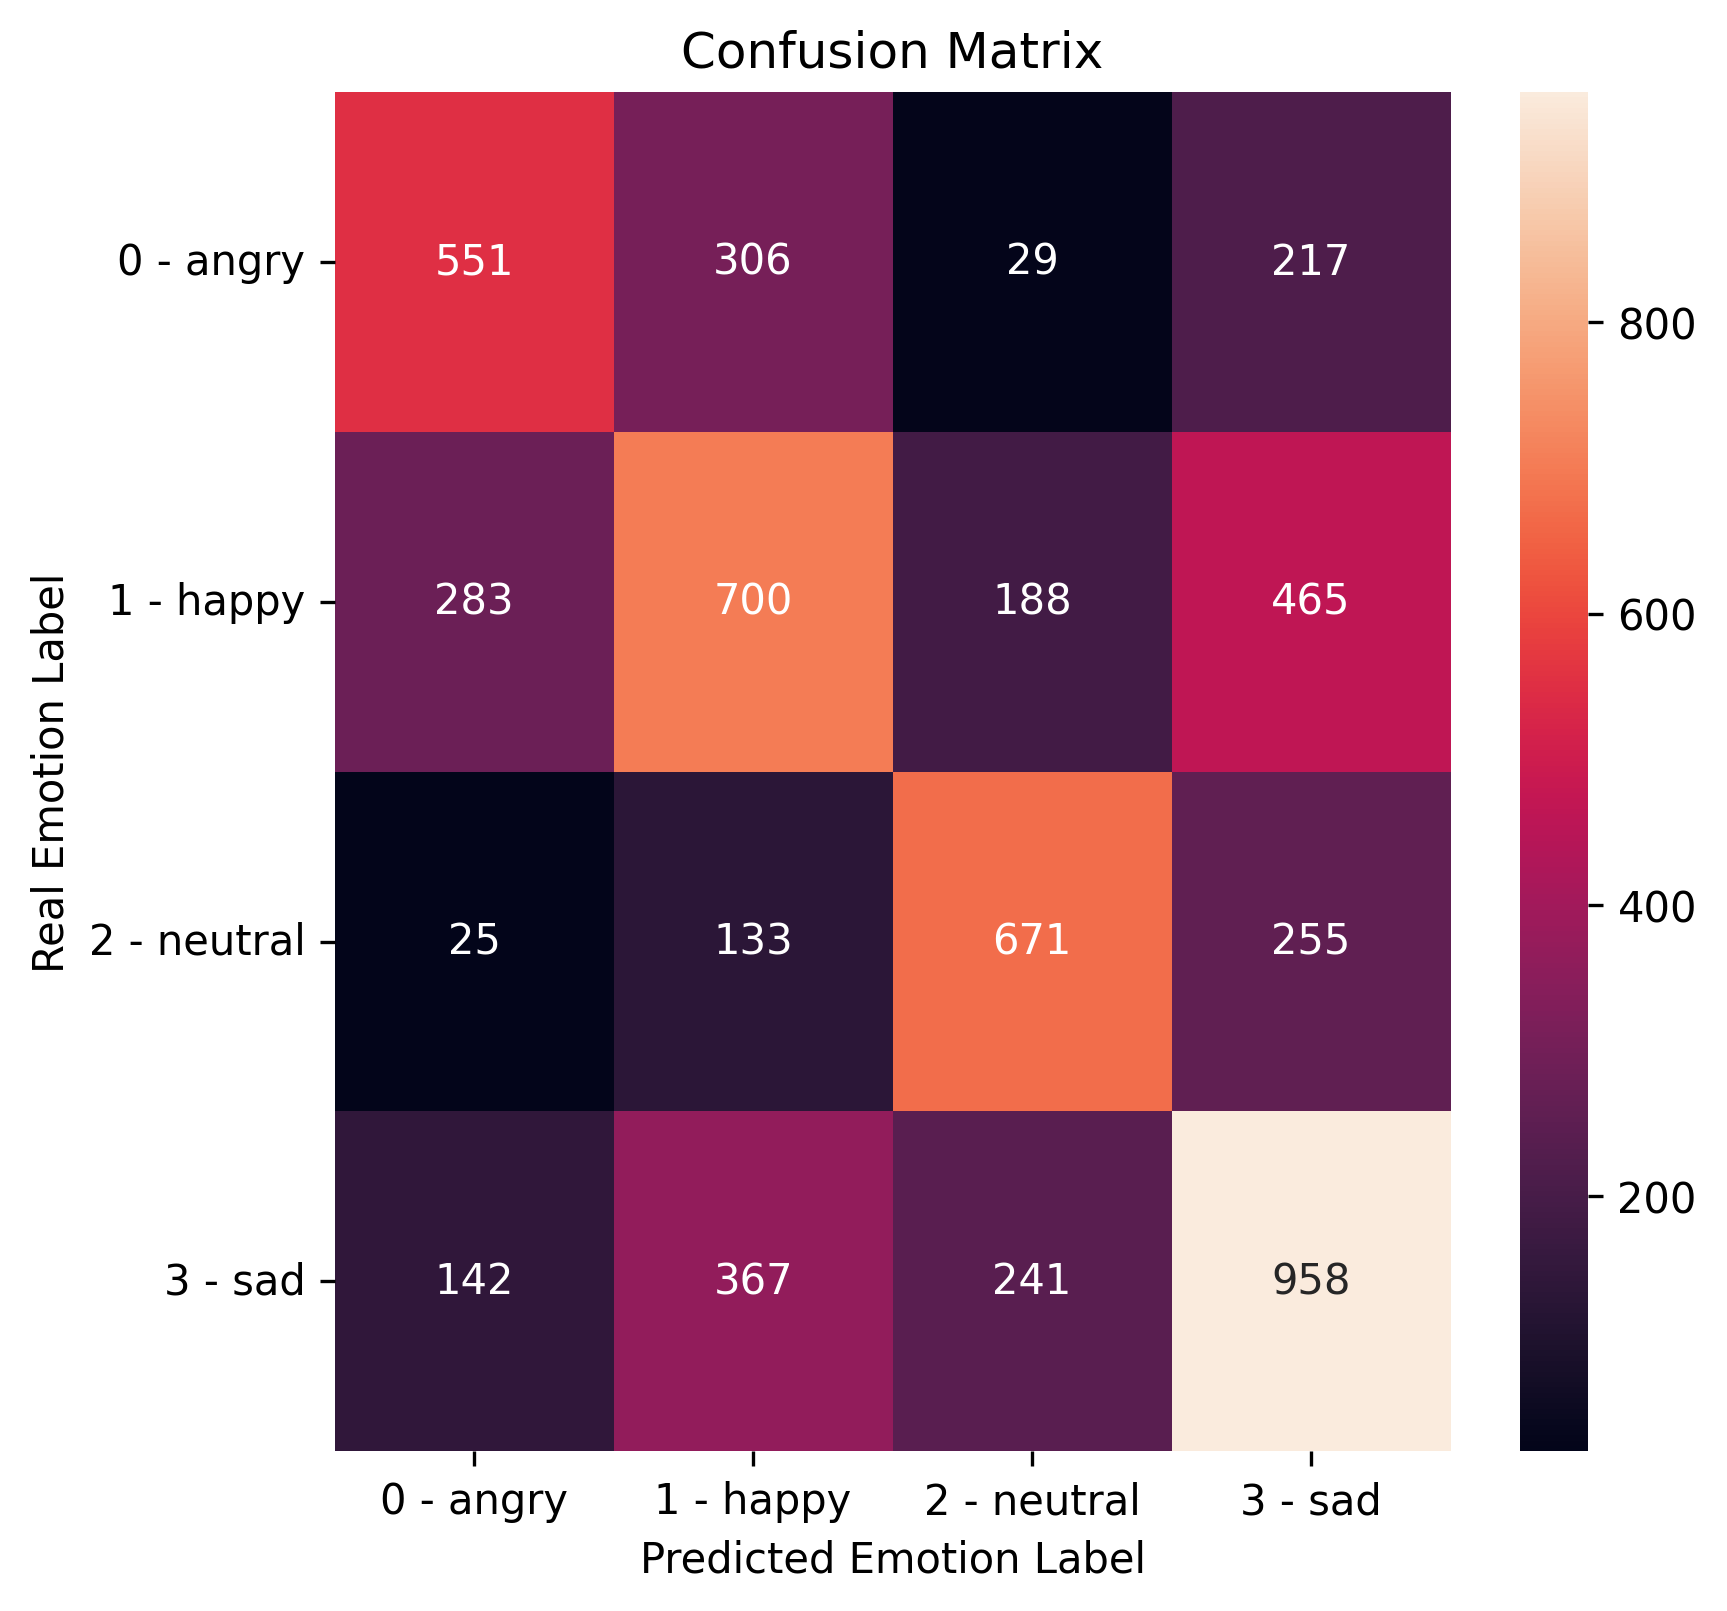

In [6]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

AlexNet Transfer Learning

In [7]:
def build_alexNet_model(input_shape, loss, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(
            4, 4), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(
            5, 5), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(
            3, 3), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(
            3, 3), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(
            3, 3), strides=(1, 1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model


def get_new_model():
    input_shape = (256, 256, 3)
    learning_rate = 0.001
    loss = SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    return build_alexNet_model(input_shape, loss, optimizer)


y_labels = categorical_cross_validation(
    get_new_model, callback, no_epochs, batch_size, verbosity, num_folds)


Training for fold 1 ...
Epoch 1/50
39/70 [===============>..............] - ETA: 48s - loss: 2.6765 - accuracy: 0.2688

KeyboardInterrupt: 

In [ ]:
all_y_labels, all_y_pred = y_labels
get_metrics(all_y_labels, all_y_pred, True)

## Results

In [35]:
headers = ["Model", "Input Size", "Accuracy", "Macro F1", "Micro F1", "Precision", "Recall", "MCC."]

results = [
    ["Random Forest", 24, 0.5876, 0.5957, 0.5876, 0.6038, 0.5918, 0.4410],
    ["Linear Discriminant Analysis", 24, 0.5588, 0.5683, 0.5588, 0.5700, 0.5687, 0.4033],
    ["Histogram Gradient Boosting", 24, 0.6010, 0.6091, 0.6010, 0.6140, 0.6066, 0.4603],
    ["AutoSK Ensemble", 24, 0.6035, 0.6120, 0.6035, 0.6174, 0.6114, 0.4642],
    ["Simple CNN", 24, 0.4562, 0.4622, 0.4562, 0.4856, 0.4613, 0.2649],
    ["AutoKeras NN", 24, 0.4280, 0.4206, 0.4280, 0.4783, 0.4083, 0.2109],
    ["AutoKeras NN", 5024, 0.4681, 0.4680, 0.46812, 0.4724, 0.4696, 0.2813],
    ["AutoKeras NN", 5048, 0.5050, 0.5085, 0.5050, 0.5078, 0.5192, 0.3361],
]

print(tabulate(results, headers=headers, tablefmt="github"))

| Model                        |   Input Size |   Accuracy |   Macro F1 |   Micro F1 |   Precision |   Recall |   MCC. |
|------------------------------|--------------|------------|------------|------------|-------------|----------|--------|
| Random Forest                |           24 |     0.5876 |     0.5957 |    0.5876  |      0.6038 |   0.5918 | 0.441  |
| Linear Discriminant Analysis |           24 |     0.5588 |     0.5683 |    0.5588  |      0.57   |   0.5687 | 0.4033 |
| Histogram Gradient Boosting  |           24 |     0.601  |     0.6091 |    0.601   |      0.614  |   0.6066 | 0.4603 |
| AutoSK Ensemble              |           24 |     0.6035 |     0.612  |    0.6035  |      0.6174 |   0.6114 | 0.4642 |
| Simple CNN                   |           24 |     0.4562 |     0.4622 |    0.4562  |      0.4856 |   0.4613 | 0.2649 |
| AutoKeras NN                 |           24 |     0.428  |     0.4206 |    0.428   |      0.4783 |   0.4083 | 0.2109 |
| AutoKeras NN                 |